## Contents  <a id='part-0'>
-------------------
- [Motivation](#Motivation)
- [Data](#Data)
- [Experimental Setup](#Experiment)
- [Approach](#Approach)
    * [Exploratory Data Analysis](#EDA)
        * [Distribution of question length](#distribution)
        * [Find Top words](#TopWords)
        * [Bad Words Analysis](#BadWords)
        * [Bad words Extent](#BadWords2)
    * [Topic Modelling](#Topic)
        * [Topic modelling for insincere question](#InsincereTopic)
        * [Topic modelling for sincere question](#SincereTopic)
    * [Preprocessing](#Preprocessing)
    * [Word Embeddings](#WordEmbeddings)
    * [DNN Models](#DNNModels)
        * [LSTM with Attention](#LSTM)
        * [Capsule](#Capsule)
        * [CNN](#CNN)
    * [FastAI - Universal Language Model Fine-tuning (ULMFiT)](#FastAI)
    * [Feature Engineering and Integration](#FeatureEngineering)
        * [Add more numeric features](#numericfeatures)
        * [Topic factors from topic modeling](#TopicFactors)
        * [Modify the DNN model to include new features in the model](#IncludeNewFeatures)
    * [Ensemble and Cross Validation](#Ensemble)
    * [Strafied cross validation](#Strafied)
- [Results](#Results)
    * [Analysis of the Results](#AnalysisResults)
- [Future Work](#Future)

## Motivation <a id='Motivation'></a>

In this project, we participated a Kaggle Competition: Quara Insincere Qustions Classification, where we will develop models that identify and flag insincere questions. An existential problem for any major website today is how to handle toxic and divisive content. A key challenge facing Quora is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.  To date, Quora has employed both machine learning and manual review to address this problem. With the launch of thie competition, Quora is hoping to develop more scalable methods to detect toxic and misleading content, thus keeping its platform a place where users can feel safe sharing their knowledge with the world. Following are some characteristics that can signify that a question is insincere:
- Has a non-neutral tone
    * Has an exaggerated tone to underscore a point about a group of people
    * Is rhetorical and meant to imply a statement about a group of people
- Is disparaging or inflammatory
    * Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
    * Makes disparaging attacks/insults against a specific person or group of people
    * Based on an outlandish premise about a group of people
    * Disparages against a characteristic that is not fixable and not measurable
* Isn't grounded in reality
    * Based on false information, or contains absurd assumptions
* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

## Data <a id='Data'></a>
We are provided with train.csv, with coumns question_text and target indicating whether correspoinding test is sincere or not, test.csv. Train set contains 1306122 sentences, among which 6.19% are positive. Test set contains 56370 sentences.  
There are also four different types of word embeddings: Word2Vec, GLOVE, FastText and Paragram. Word embeddings, loosely speaking, are vector representations of a particular word. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, so that words with similar context occupy close spatial positions. 



In [12]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import gc
import time
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.autonotebook import tqdm
tqdm.pandas()

import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, Conv2D
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K
from keras.callbacks import *

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import KeyedVectors

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Custom Packages:
# - Spelling checker: https://github.com/phatpiglet/autocorrect
# - Split words: https://github.com/keredson/wordninja

# For EDA and possibly preprocessing
from autocorrect import spell
import wordninja

# show more text on output
pd.set_option('display.max_colwidth', -1)

In [2]:
# Custom Tokenize function
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer


def tokenize(sentence, tool="nltk", mapping={}, keep_num=False, keep_punc=False):
    punctuations = string.punctuation
    if tool == "spacy":
        parser = English()
        spacy_stopwords = list(STOP_WORDS)
        
        def __tokenizer(sentence):
            words = parser(sentence)
            for w in words:
                if keep_punc or str(w) not in punctuations:
                    if keep_num or not str(w).isnumeric():
                        if w in mapping:
                            w = mapping[w]
                        w = w.lemma_.lower().strip() if w.lemma_ != "-PRON-" else w.lower_
                        yield w
        
    elif tool == "nltk":
        tokenizer = TweetTokenizer()
        wnl = WordNetLemmatizer()
        stop_words = set(stopwords.words("english"))
        
        def __tokenizer(sentence):
            words = tokenizer.tokenize(sentence)
            for w in words:
                if keep_punc or str(w) not in punctuations:
                    if keep_num or not str(w).isnumeric():
                        if w in mapping:
                            w = mapping[w]
                        yield wnl.lemmatize(w, "v").lower()
    return __tokenizer(sentence)

In [3]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


## Experimental Setup <a id='Experiment'></a>
### Evaluation
Submissions are evaluated on F1 Score between the predicted and the observed targets.
### Runtime
This is a Kernels Only Competition, requiring that all submissions be made via a Kernel output. Kaggle Kernel is a versioned computational environment designed to make it easy to reproduce data science work. In the Kernels IDE, we have access to an interactive session running in a Docker container with pre-installed packages, the ability to mount versioned data sources, customizable compute resources like GPUs (NVIDIA Tesla K80) and more.  
When a kerneal is commited, it is executed from top to bottom in a separate session. Once finished, it outputs the results ready for submission. Only results finished executing within 2 houts can be submitted to the Leaderboard, so that the use of over-complicated models are prevented.  

## Approach <a id='Approach'></a>

### Exploratory Data Analysis <a id='EDA'></a>

The purpose of Exploratory Data Analysis is to understand the original data by making fewer assumptions. The methods include analyzing the distribution of data, exploring the abnormal value and so on.  
(credits to https://www.kaggle.com/thebrownviking20/analyzing-quora-for-the-insinceres)

#### Distribution of question length <a id='distribution'></a>
Insincere questions have longer sentences, which is a potential valuable feature. 

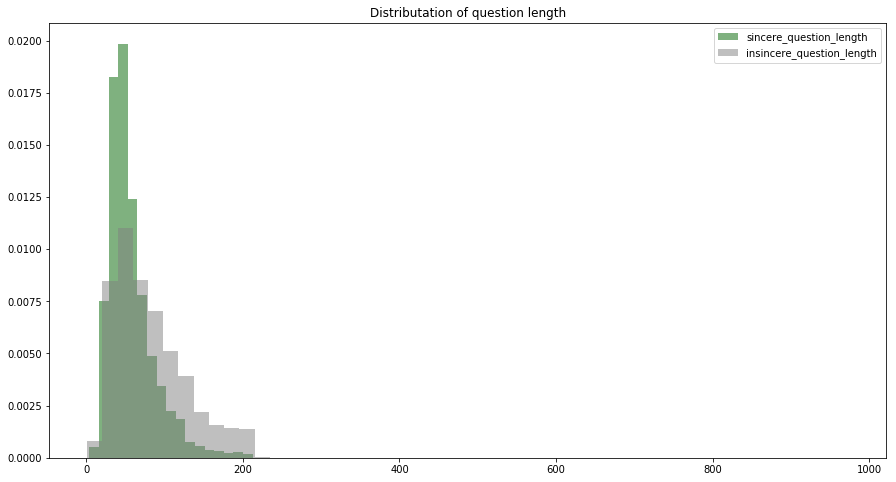

In [7]:
insincere_df = train_df[train_df['target'] == 1]
insincere_question_length=insincere_df["question_text"].apply(lambda x: len(''.join(x.split())))
sincere_df = train_df[train_df['target'] == 0]
sincere_question_length =sincere_df["question_text"].apply(lambda x: len(''.join(x.split())))

plt.figure(figsize = (15, 8))

plt.title('Distributation of question length')
plt.hist(sincere_question_length, bins=50, density=True, alpha=0.5, histtype='stepfilled', color='darkgreen', label = "sincere_question_length")
plt.hist(insincere_question_length, bins=50, density=True, alpha=0.5, histtype='stepfilled', color='gray', label = 'insincere_question_length')
plt.legend()

#### [Readability tests](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests)  <a id='Readability'></a>
They are designed to indicate how difficult a paragrahe is and how to improve it. From the distributions of both Flesch-Kincaid reading ease score and grade level we can tell that the insincere question is easiler to understand. And sincere questions tend to be more complicated. 
- Flesch–Kincaid readability test and its interpretation
<table>
<tr>
<td> <img src="https://contentmarketinginstitute.com/wp-content/uploads/2016/01/flesch-kincaid-equation-600x92.jpg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="https://myenglishcamp.files.wordpress.com/2013/08/flesch-kincaid-reading-ease.jpg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>
- Flesch–Kincaid grade level and its interpretation
<table>
<tr>
<td> <img src="https://contentmarketinginstitute.com/wp-content/uploads/2016/01/flesch-kincaid-grade-level-test.jpg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="https://myenglishcamp.files.wordpress.com/2013/08/dale-chall-readibility-formula.jpg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

In [7]:
def calculate_flesch_reading_ease_score(sentence):
    total_words = set(sentence.split())
    total_words_count = len(total_words)
    total_sentences_count = len(total_words)
    total_syllables_count = len(set(" ".join([i for i in list(total_words)])))
    return 206.835 - 1.015 * (total_words_count / float(total_sentences_count)) - 84.6 * (total_syllables_count / float(total_words_count))
  
def calculate_flesch_kincaid_grade_level(sentence):
    total_words = set(sentence.split())
    total_words_count = len(total_words)
    total_sentences_count = len(total_words)
    total_syllables_count = len(set(" ".join([i for i in list(total_words)])))
    return 0.39*(total_words_count / float(total_sentences_count)) + 11.8*(total_syllables_count / float(total_words_count)) - 15.59
  
train_df["flesch_reading_ease_score"] = train_df["question_text"].apply(calculate_flesch_reading_ease_score)
train_df["flesch_kincaid_grade_level"] = train_df["question_text"].apply(calculate_flesch_kincaid_grade_level)

insincere_df = train_df[train_df['target'] == 1]
sincere_df = train_df[train_df['target'] == 0]

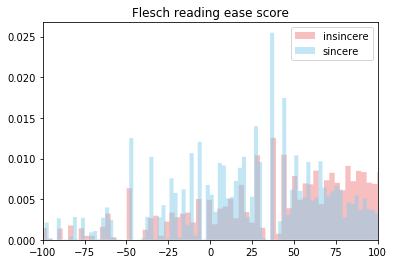

In [8]:
plt.title('Flesch reading ease score')
plt.hist(insincere_df["flesch_reading_ease_score"].tolist(), bins=500, density=True, alpha=0.5, histtype='stepfilled', color='lightcoral', label = 'insincere')
plt.hist(sincere_df["flesch_reading_ease_score"].tolist(), bins=500, density=True, alpha=0.5, histtype='stepfilled', color='skyblue', label = 'sincere')
plt.legend()
plt.xlim(-100,100)
plt.show()

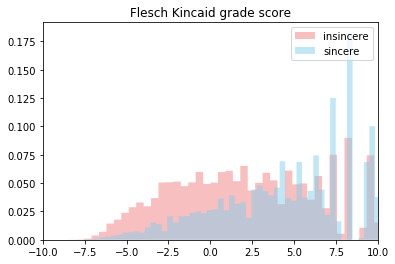

In [9]:
plt.title('Flesch Kincaid grade score')
plt.hist(insincere_df["flesch_kincaid_grade_level"].tolist(), bins=500, density=True, alpha=0.5, histtype='stepfilled', color='lightcoral', label = 'insincere')
plt.hist(sincere_df["flesch_kincaid_grade_level"].tolist(), bins=500, density=True, alpha=0.5, histtype='stepfilled', color='skyblue', label = 'sincere')
plt.legend()
plt.xlim(-10,10)
plt.show()

In [10]:
# We wont use this in later section
del train_df["flesch_reading_ease_score"]
del train_df["flesch_kincaid_grade_level"]

#### Find Top words <a id='TopWords'></a>

Finding top words may give us insignt about word distributation, we may see interesting result from this.

Method:

1. Count word freq on both side
2. Remove top common words (Threshold = 1000)   
*Some people do NOT remove common words,  there are other ways of doing so, such as using TF.IDF sorce, however, using TF.IDF may result in bias on sincere words (sincere has more words then insincere for sure...) which will lead to bad results

In [11]:
import itertools

def top_words(sent, top=20):
    ngram_list = list(itertools.chain.from_iterable(sent.values))
    return pd.Series(ngram_list).value_counts()[:top]
  
sincere = train_df[train_df["target"] == 0]
insincere = train_df[train_df["target"] == 1]

sincere_tokenize = sincere["question_text"].apply(tokenize)
insincere_tokenize = insincere["question_text"].apply(tokenize)

top_sincere = top_words(sincere_tokenize, 1500)
top_insincere = top_words(insincere_tokenize, 1500)

In [12]:
top_common = set(top_sincere.index) & set(top_insincere.index)
list(top_common)[:10]

['fake',
 'lose',
 'out',
 'abuse',
 'check',
 'behind',
 'ban',
 'along',
 'average',
 'skin']

In [13]:
top_200_sincere_words = top_sincere[~top_sincere.index.isin(top_common)][:200]
top_200_insincere_words = top_insincere[~top_insincere.index.isin(top_common)][:200]
# Save for later use
# pd.DataFrame({"word":top_200_insincere_words.index}).to_csv("top_200_insincere_words.csv")

In [19]:
def plot_pandas(pd, title=""):
    color_brewer = ['#FFD5D5','#FFD5D5','#FFD5D5','#FFD5D5','#FFD5D5','#FFD5D5','#FFD5D5','#FFD5D5','#FFD5D5','#FFD5D5',
                    '#FFD5D5','#FFD5D5','#FFD5D5','#FFD5D5','#FFD5D5','#FFAAAA','#FF8080','#FF5555','#FF2A2A','#FF0000']
    sort_pd = pd[:20].sort_values(ascending=True)
    X = sort_pd.values
    Y = sort_pd.index
    trace = [go.Bar(
                y=Y,
                x=X,
                orientation = 'h',
                marker=dict(color=color_brewer, line=dict(color='rgb(8,48,107)',width=1.5,)),
                opacity = 0.75
    )]
    layout = go.Layout(
        title=title,
        margin = go.Margin(
            l = 200,
            r = 400
        )
    )

    fig = go.Figure(data=trace, layout=layout)
    iplot(fig, filename='horizontal-bar')

In [20]:
plot_pandas(top_200_sincere_words[~top_200_sincere_words.index.isin(
        set(stopwords.words("english")) | set(["What", "How", "Why", "Which"])
      )], 
      "Top Sincere Words (Exclude Common and Stop words)")

C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




In [21]:
plot_pandas(top_200_insincere_words, "Top Insincere Words (Exclude Common)")

C:\ProgramData\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:396: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




In [ ]:
# clean up
del top_sincere
del top_insincere
del top_common
del top_200_sincere_words
del top_200_insincere_words

The result seems very reasonable, for example : Jews, Racist, Hillary, Democrats are all have quit strong personal perspective, which results in top words of insincere questions.

On the other hand, words like " bad , would , like , good " are more like question words resulting in Sincere Questions. However, these words are more of common question words and are not representative. Thus, we decided to add Top Insincere words to our hand-crafted features.

#### Bad Words Analysis  <a id='BadWords'></a>
We have an idea that Bad word in the question could be one of the critical reason being marked as insincere, so we test this by comparing the appearance of bad words in both sincere and insincere questions. Here are some source we used:  
Source of bad word list   
  - youtube: https://www.freewebheaders.com/youtube-blacklist-words-list_youtube-comment-moderation/   
  - google: https://www.freewebheaders.com/full-list-of-bad-words-banned-by-google/   
  - facebook: https://www.freewebheaders.com/bad-words-list-and-page-moderation-words-list-for-facebook/
 

In [22]:
# From google/facebook bad word list 
# Excluded sexy, dummy, dirty, hard core
bad_word_reg = r"""
  anal[ \n\r\W?]*| anus| arse| ass[ \n\r\W?]+| ass fuck| ass hole| assfucker| asshole| assshole| bastard| bitch| black cock| bloody hell
| boong| cock| cockfucker| cocksuck| cocksucker| coon[ \n\r\W?]*| coonnass| crap| cunt| cyberfuck| damn[ \n\r\W?]*| darn[ \n\r\W?]*
| dick[ \n\r\W?]*| douche| erect[ \n\r\W?]*| erection| erotic| escort| fag| faggot| fuck| Fuck off| fuck you| fuckass| fuckhole
| god damn| gook[ \n\r\W?]*| hardcore| homoerotic| hore| lesbian| lesbians| mother fucker| motherfuck| motherfucker| negro| nigger
| orgasim| orgasm| penis| penisfucker| piss| piss off| porn[ \n\r\W?]*| porno[ \n\r\W?]*| pornography[ \n\r\W?]*| pussy[ \n\r\W?]*
| retard| sadist| shit | slut| son of a bitch| suck| tits[ \W]| viagra| whore| xxx[ \n\r\W?]*| sex[ \n\r\W?]*| rape[dry]*| raping[ \n\r\W?]*
| rapist[ \n\r\W?]*| raunch[ \n\r\W?]*| rectal[ \n\r\W?]*| rectum[ \n\r\W?]*| rectus[ \n\r\W?]*| reefer[ \n\r\W?]*| reetard[ \n\r\W?]*"""

train_df['bad_word'] = 1
train_df['bad_word'] = train_df['bad_word'].where(train_df['question_text'].str.contains(bad_word_reg), 0)

train_df[train_df['bad_word'] == 1].sample(frac=0.1)[["question_text", "target"]].head()

,question_text,target
156238,Do you know any reliable gay amateur porn sites that can amaze me fascinatingly?,0
1053846,"In many of the South Asian countries, sex and sex related matters are not discussed openly, is it only because of the lack of health ane swx education?",0
1019398,I'm always hearing this bullshit about living life to the fullest. What the fuck does that mean and how does one do that while mentally disabled?,0
561839,How do I satisfy my sexual desires with a girlfriend who wants to wait until marriage before sex?,0
623773,Why do women prefer men with big penises?,1


In [23]:
tp = train_df[(train_df['target'] == 1) & (train_df['bad_word'] == 1)][['qid']].count()
tn = train_df[(train_df['target'] == 0) & (train_df['bad_word'] == 0)][['qid']].count()
fp = train_df[(train_df['target'] == 1) & (train_df['bad_word'] == 0)][['qid']].count()
fn = train_df[(train_df['target'] == 0) & (train_df['bad_word'] == 1)][['qid']].count()
print(f"Precision : {tp/(tp+fp)}")
print(f"Recall : {tp/(tp+fn)}")

Precision : qid    0.098329
dtype: float64
Recall : qid    0.339268
dtype: float64


Looking at the results,  we got precsison 0.098 and recall 0.3392, which is not as good as we think,  but then, when we rethink about this, it actually make sense: Precision means that the question is marked by insincere because of bad words, which , is not the case. Recall means that if there is bad words in the sentances , then it could be insincere, which maybe the case. However, we got about 0.33 for recall, which means that some question are still in sincere even there are bad words in it.

In result, we can not simply judge by looking at the bad words, but maybe we can judge by looking at super bad words (such as "fuck" or so), lets see the detail in next section.

#### Bad words Extent  <a id='BadWords2'></a>
Find bad words that only happen in insincere questions

In [24]:
# We only list a few here, since it is terribly slow to compute all bad words
bad_word_reg_test = r"(?P<rape> rape[dry]*[ \n\r\W?]*)?(?P<raping> raping*[ \n\r\W?]*)?(?P<anus> anus[ \n\r\W?]*)?(?P<arse> arse[ \n\r\W?]*)?(?P<ass> ass[ \n\r\W?]*)?(?P<ass_hole> as[s ]+hole[ \n\r\W?]*)?(?P<bastard> bastard[ \n\r\W?]*)?(?P<bitch> bitch[ \n\r\W?]*)?(?P<fuck> fuck[eroffyu as]*[ \n\r\W?]*)?(?P<pussy> pussy [ \n\r\W?]*)?(?P<retard> retard[ \n\r\W?]*)?(?P<viagra> viagra[ \n\r\W?]*)?(?P<whore> whore[ \n\r\W?]*)?(?P<sex> sex[ \n\r\W?]*)?(?P<reetard> reetard[ \n\r\W?]*)?"

In [26]:
%%time
# Very slow here ...
bad_words_df = train_df['question_text'].str.extractall(bad_word_reg_test)

Wall time: 9min 46s


In [32]:
bad_word_analysis_result = bad_words_df.reset_index().rename(columns={"level_0": 'id'}).merge(train_df.reset_index().rename(columns={"index": 'id'})[['id','target']], on='id')
bad_word_analysis_result.head()

,id,match,rape,raping,anus,arse,ass,ass_hole,bastard,bitch,fuck,pussy,retard,viagra,whore,sex,reetard,target
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [35]:
bad_word_analysis_result[~bad_word_analysis_result['rape'].isnull()].head()

,id,match,rape,raping,anus,arse,ass,ass_hole,bastard,bitch,fuck,pussy,retard,viagra,whore,sex,reetard,target
16140,219,71,rape/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
122104,1680,18,rape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
204609,2865,122,rape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
234521,3284,48,rape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
294483,4131,94,rape,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [34]:
for col in list(bad_word_analysis_result):
    if col not in ['id', 'match', 'target']:
        temp = bad_word_analysis_result[~bad_word_analysis_result[f'{col}'].isnull()]
        temp_ratio = temp[temp['target'] == 1]['id'].count()/temp['id'].count()
        print(f"{col}: {temp_ratio}")

rape: 0.5702036441586281
raping: 0.7791411042944786
anus: 0.41
arse: 0.24444444444444444
ass: 0.14762850757387633
ass_hole: nan
bastard: 0.6216216216216216
bitch: 0.5892857142857143
fuck: 0.7097118463180363
pussy: 0.6336633663366337
retard: 0.35833333333333334
viagra: nan
whore: 0.6521739130434783
sex: 0.28569310600444775
reetard: nan


In [36]:
# Clean up
del bad_word_analysis_result
del train_df['bad_word']
gc.collect()

467

By looking at the results:   
**This was done in my notebook, may have small difference when running from this notebook due to changing text cleaning method and so...
​
- rape: 0.5677830940988836
- raping: 0.7791411042944786
- anus: 0.37037037037037035
- arse: 0.2391304347826087
- ass: 0.12306277909114789
- ass_hole: 0.7272727272727273
- bastard: 0.6216216216216216
- bitch: 0.5877192982456141
- fuck: 0.708029197080292
- pussy: 0.6407766990291263
- retard: 0.35833333333333334
- viagra: nan
- whore: 0.6521739130434783
- sex: 0.2857142857142857
- reetard: nan   

We found very interesting results, some works are way more often to appears in insincere questions then sincere questions,  and some may happen in both or even more in sincere ( this is because of the raito difference, there are only 6.19% insincere).
​
This result is also explainable, for words like "retard", "sex", "ass", it could be noun with neual meaning, but "fuck", "ass_hole", "pussy" are more chance to be curse words. By these result, we decided to add words with ratio > 0.55 to our hand-crafted features. 
​
During our test, we also tried to manually adjust result based on these bad word list (for example: we change all questions containing "fuck" to 1 after prediction). However, the result is not as good as before, meaning that the model has already considered these.

### Topic Modelling <a id="Topic"></a>

Topic Modeling is an unsupervised learning approach to clustering documents, to discover topics based on their contents. We have tried Latent Dirichlet Allocation (LDA) to analysis the questions.
(credits to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

Cleaning is an important step before any text mining task. In order to make sure that the topic model is identifying interesting or important patterns instead of noise, we had to accomplish the following pre-processing steps.


*   Remove stop words: these words are extremely common in English so we don't consider them. Such as 'the', 'did',...
*   Remove punctuation
*   Lemmatized  words: words in third person are changed to first person and verbs are changed into present sense. 
*   Stemmed words: words are reduced to their root form. 



In [4]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in set(stopwords.words('english'))])
    punc_free = ''.join(ch for ch in stop_free if ch not in set(string.punctuation))
    stemmer = " ".join([PorterStemmer().stem(i) for i in punc_free])
    normalized = " ".join(WordNetLemmatizer().lemmatize(word) for word in stop_free.split())
    return normalized

Perplexity is a way to measure how good a topic modelling is. The idea is to keep a holdout sample and train on the rest of the data, then calcualte the preplexity of the holdout. lower the better.

Some times perplexity is not good enough to give human a good judgment, coherence is another way to analysis the model. 

In [5]:
def compute_perplexity_coherence_values(dictionary, corpus, start, stop, step, iteration):
    perplexity_values = []
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print("current number of topic", num_topics)
        start = time.time()
        model = gensim.models.LdaMulticore(corpus, num_topics, dictionary, iteration)
        model_list.append(model)
        coherence = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherence.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))
        done = time.time()
        elapsed = done - start
        print(elapsed)
    return perplexity_values, coherence_values, model_list

#### Topic modelling for insincere question <a id="InsincereTopic"></a>

In [8]:
%%time
preprocessed_data = [clean(doc).split() for doc in insincere_df['question_text'].tolist()]

Wall time: 8min


In [9]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(preprocessed_data)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_data]

In [14]:
%%time
perplexity_values, coherence_values, model_list = compute_perplexity_coherence_values(dictionary, corpus, start = 1, stop = 20, step = 3, iteration = 50)

current number of topic 1
28.538591146469116
current number of topic 4
61.27840614318848
current number of topic 7
56.46142625808716
current number of topic 10
54.50559091567993
current number of topic 13
54.128448724746704
current number of topic 16
52.902000188827515
current number of topic 19
53.42440629005432
Wall time: 6min 1s


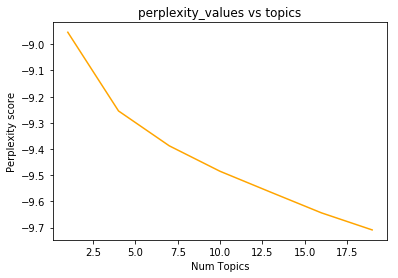

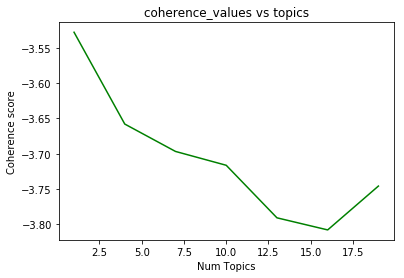

In [15]:
plt.plot(list(range(1, 20, 3)), perplexity_values, color = 'orange')
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.title("perplexity_values vs topics")
plt.show()

plt.plot(list(range(1, 20, 3)), coherence_values, color = 'green')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("coherence_values vs topics")

plt.show()

In [16]:
best_perplexity_model = model_list[perplexity_values.index(min(perplexity_values))]
best_coherence_model =model_list[coherence_values.index(min(coherence_values))]

In [17]:
# Visualize the topics of best_perplexity_model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_perplexity_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.014104 -0.006065  1       1        6.707514
18    -0.002820 -0.010051  2       1        6.476418
4      0.011736  0.028400  3       1        6.422336
13    -0.050601  0.033165  4       1        5.854619
1     -0.006748  0.004588  5       1        5.653497
12     0.008881 -0.057116  6       1        5.646232
0      0.005621 -0.042631  7       1        5.601155
17    -0.006519  0.020705  8       1        5.521878
14    -0.021320 -0.042825  9       1        5.467200
3      0.012436 -0.024885  10      1        5.127417
7     -0.038862  0.016881  11      1        5.047046
10    -0.032476 -0.000520  12      1        4.953426
9     -0.007571  0.020785  13      1        4.859341
15     0.024618 -0.029502  14      1        4.777521
6     -0.028462  0.043408  15      1        4.757018
8      0.040294  0.044756  16      1        4.652238
16    -0.016836 -0.011368  17      1        4.614634
2      0.001400 -0.014518  18      1        4.056031
5      0.093124  0.026794  19      1        3.804491, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
49    Default  5146.000000   woman        5146.000000   30.0000  30.0000
146   Default  10073.000000  people       10073.000000  29.0000  29.0000
204   Default  4143.000000   muslim       4143.000000   28.0000  28.0000
369   Default  5240.000000   like         5240.000000   27.0000  27.0000
266   Default  2565.000000   girl         2565.000000   26.0000  26.0000
13    Default  2843.000000   black        2843.000000   25.0000  25.0000
423   Default  2908.000000   men          2908.000000   24.0000  24.0000
381   Default  3052.000000   get          3052.000000   23.0000  23.0000
247   Default  4675.000000   indian       4675.000000   22.0000  22.0000
131   Default  4515.000000   trump        4515.000000   21.0000  21.0000
43    Default  3716.000000   american     3716.000000   20.0000  20.0000
552   Default  3313.000000   white        3313.000000   19.0000  19.0000
98    Default  3739.000000   would        3739.000000   18.0000  18.0000
145   Default  2062.000000   hate         2062.000000   17.0000  17.0000
176   Default  3221.000000   many         3221.000000   16.0000  16.0000
440   Default  1286.000000   hindu        1286.000000   15.0000  15.0000
745   Default  1210.000000   democrat     1210.000000   14.0000  14.0000
470   Default  1021.000000   guy          1021.000000   13.0000  13.0000
64    Default  1084.000000   year         1084.000000   12.0000  12.0000
346   Default  3566.000000   think        3566.000000   11.0000  11.0000
248   Default  853.000000    north        853.000000    10.0000  10.0000
431   Default  1257.000000   christian    1257.000000   9.0000   9.0000 
151   Default  1907.000000   country      1907.000000   8.0000   8.0000 
274   Default  1612.000000   one          1612.000000   7.0000   7.0000 
123   Default  2224.000000   liberal      2224.000000   6.0000   6.0000 
279   Default  943.000000    stop         943.000000    5.0000   5.0000 
1150  Default  846.000000    man          846.000000    4.0000   4.0000 
209   Default  1881.000000   sex          1881.000000   3.0000   3.0000 
59    Default  1506.000000   say          1506.000000   2.0000   2.0000 
1233  Default  886.000000    asian        886.000000    1.0000   1.0000 
...       ...          ...   ...                  ...      ...      ... 
3413  Topic19  18.392313     eu           116.549126    1.4226  -7.3465 
5     Topic19  50.810139     world?       617.336121    0.7717  -6.3303 
281   Topic19  108.308182    u            2194.345703   0.2603  -5.5735 
151   Topic19  98.043045     country      1907.744141   0.3007  -5.6730 
1267  Topic19  69.682297     child        1073.759766   0.5340  -6.0145 
369   Topic19  172.647049    like         5240.982910  -0.1440  -5.107

In [18]:
# Visualize the topics of best_coherence_model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_coherence_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6      0.000860  0.003193  1       1        7.853954
9      0.001771 -0.006254  2       1        6.940010
8     -0.001359  0.011062  3       1        6.821341
12    -0.024089  0.012375  4       1        6.533654
11     0.010067  0.018008  5       1        6.471045
10    -0.021151  0.012990  6       1        6.467159
1     -0.004286  0.033381  7       1        6.406736
5      0.025432  0.035254  8       1        6.396883
15     0.040998 -0.014565  9       1        6.285180
13    -0.062996  0.019359  10      1        6.027844
3     -0.007613 -0.034941  11      1        5.951909
14     0.064163  0.019618  12      1        5.931642
2     -0.041474 -0.029887  13      1        5.619741
0      0.031035  0.015645  14      1        5.548475
7     -0.032893 -0.005132  15      1        5.391638
4      0.021536 -0.090106  16      1        5.352790, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
146   Default  10053.000000  people      10053.000000  30.0000  30.0000
131   Default  4524.000000   trump       4524.000000   29.0000  29.0000
49    Default  5101.000000   woman       5101.000000   28.0000  28.0000
369   Default  5279.000000   like        5279.000000   27.0000  27.0000
43    Default  3719.000000   american    3719.000000   26.0000  26.0000
346   Default  3520.000000   think       3520.000000   25.0000  25.0000
209   Default  1885.000000   sex         1885.000000   24.0000  24.0000
247   Default  4651.000000   indian      4651.000000   23.0000  23.0000
216   Default  1860.000000   india       1860.000000   22.0000  22.0000
266   Default  2548.000000   girl        2548.000000   21.0000  21.0000
204   Default  4063.000000   muslim      4063.000000   20.0000  20.0000
552   Default  3310.000000   white       3310.000000   19.0000  19.0000
381   Default  3053.000000   get         3053.000000   18.0000  18.0000
123   Default  2227.000000   liberal     2227.000000   17.0000  17.0000
145   Default  2062.000000   hate        2062.000000   16.0000  16.0000
253   Default  1682.000000   chinese     1682.000000   15.0000  15.0000
731   Default  1365.000000   donald      1365.000000   14.0000  14.0000
176   Default  3235.000000   many        3235.000000   13.0000  13.0000
35    Default  2425.000000   want        2425.000000   12.0000  12.0000
745   Default  1208.000000   democrat    1208.000000   11.0000  11.0000
98    Default  3752.000000   would       3752.000000   10.0000  10.0000
104   Default  1605.000000   even        1605.000000   9.0000   9.0000 
1008  Default  642.000000    men?        642.000000    8.0000   8.0000 
1150  Default  852.000000    man         852.000000    7.0000   7.0000 
13    Default  2849.000000   black       2849.000000   6.0000   6.0000 
1055  Default  1064.000000   ever        1064.000000   5.0000   5.0000 
1233  Default  886.000000    asian       886.000000    4.0000   4.0000 
281   Default  2193.000000   u           2193.000000   3.0000   3.0000 
423   Default  2880.000000   men         2880.000000   2.0000   2.0000 
48    Default  1392.000000   much        1392.000000   1.0000   1.0000 
...       ...          ...   ...                 ...      ...      ... 
281   Topic16  168.642685    u           2193.554199   0.3621  -5.4721 
2945  Topic16  84.452766     racist      778.598083    0.7062  -6.1637 
251   Topic16  83.432732     south       767.764099    0.7081  -6.1758 
1397  Topic16  39.837067     deal        252.949234    1.0792  -6.9151 
131   Topic16  265.875427    trump       4524.408691   0.0933  -5.0168 
539   Topic16  62.227600     country?    502.676453    0.8384  -6.4691 
993   Topic16  69.072006     don’t       590.664734    0.7815  -6.3647 
151   Topic16  147.380646    country     1900.712769   0.3706  -5.6068 
870   Topic16  68.745270     islam       593.797363

#### Topic modelling for sincere question <a id="SincereTopic"></a>

In [28]:
%%time
preprocessed_data = [clean(doc).split() for doc in insincere_df['question_text'].tolist()]

Wall time: 8min 9s


In [29]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(preprocessed_data)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_data]

In [30]:
%%time
perplexity_values, coherence_values, model_list = compute_perplexity_coherence_values(dictionary, corpus, start = 5, stop = 40, step = 5, iteration = 50)

current number of topic 5
57.6903772354126
current number of topic 10
54.02297258377075
current number of topic 15
53.8547568321228
current number of topic 20
52.8751266002655
current number of topic 25
52.71597766876221
current number of topic 30
52.59906578063965
current number of topic 35
53.75719141960144
Wall time: 6min 17s


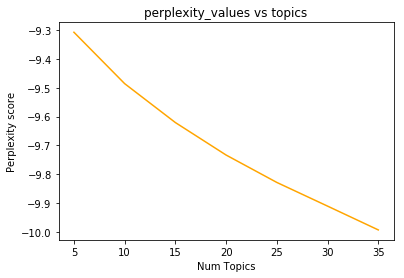

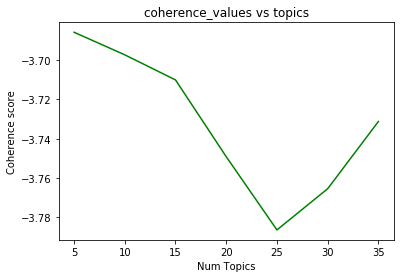

In [31]:
plt.plot(list(range(5, 40, 5)), perplexity_values, color = 'orange')
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.title("perplexity_values vs topics")
plt.show()

plt.plot(list(range(5, 40, 5)), coherence_values, color = 'green')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("coherence_values vs topics")

plt.show()

In [32]:
best_perplexity_model = model_list[perplexity_values.index(min(perplexity_values))]
best_coherence_model =model_list[coherence_values.index(min(coherence_values))]

In [33]:
# Visualize the topics of best_perplexity_model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_perplexity_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22    -0.039758  0.006403  1       1        4.319552
2     -0.040534  0.013307  2       1        3.600442
9     -0.033825 -0.017586  3       1        3.541157
18     0.003595  0.017769  4       1        3.403189
21    -0.021172  0.008124  5       1        3.368337
25    -0.019191  0.001323  6       1        3.352506
3     -0.003474 -0.016530  7       1        3.333602
29    -0.005336  0.004722  8       1        3.280295
0     -0.007245 -0.005484  9       1        3.207636
33    -0.026387 -0.029790  10      1        3.156963
13    -0.029963 -0.008692  11      1        3.134078
7     -0.027930  0.014221  12      1        3.095656
15    -0.021316  0.026809  13      1        3.077037
26     0.000456  0.031050  14      1        2.897137
30    -0.022782 -0.009981  15      1        2.855608
32    -0.000025  0.014269  16      1        2.842761
4     -0.037642 -0.014144  17      1        2.798828
34     0.030308 -0.011486  18      1        2.753985
17     0.025295 -0.016822  19      1        2.709565
27     0.017661 -0.021632  20      1        2.708686
28    -0.015823  0.014068  21      1        2.706526
1     -0.020571 -0.011075  22      1        2.656708
8      0.032713  0.036922  23      1        2.561315
10    -0.028691 -0.036991  24      1        2.552682
11     0.015052 -0.007487  25      1        2.528436
5      0.015651  0.020079  26      1        2.519852
20     0.031365 -0.033467  27      1        2.514684
6      0.025321  0.036987  28      1        2.480084
31     0.031476  0.009920  29      1        2.440115
23     0.013693  0.018928  30      1        2.328958
19     0.049932  0.092872  31      1        2.290884
12    -0.028365 -0.032111  32      1        2.290682
16    -0.005221  0.012201  33      1        2.277236
24     0.082121 -0.064473  34      1        2.228409
14     0.060610 -0.042224  35      1        2.186411, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
369   Default  5261.000000   like         5261.000000   30.0000  30.0000
247   Default  4654.000000   indian       4654.000000   29.0000  29.0000
146   Default  10080.000000  people       10080.000000  28.0000  28.0000
131   Default  4481.000000   trump        4481.000000   27.0000  27.0000
49    Default  5120.000000   woman        5120.000000   26.0000  26.0000
266   Default  2552.000000   girl         2552.000000   25.0000  25.0000
552   Default  3301.000000   white        3301.000000   24.0000  24.0000
204   Default  4068.000000   muslim       4068.000000   23.0000  23.0000
731   Default  1353.000000   donald       1353.000000   22.0000  22.0000
13    Default  2839.000000   black        2839.000000   21.0000  21.0000
281   Default  2185.000000   u            2185.000000   20.0000  20.0000
209   Default  1870.000000   sex          1870.000000   19.0000  19.0000
98    Default  3744.000000   would        3744.000000   18.0000  18.0000
381   Default  3076.000000   get          3076.000000   17.0000  17.0000
145   Default  2067.000000   hate         2067.000000   16.0000  16.0000
440   Default  1272.000000   hindu        1272.000000   15.0000  15.0000
346   Default  3537.000000   think        3537.000000   14.0000  14.0000
423   Default  2892.000000   men          2892.000000   13.0000  13.0000
176   Default  3234.000000   many         3234.000000   12.0000  12.0000
206   Default  2311.000000   quora        2311.000000   11.0000  11.0000
123   Default  2217.000000   liberal      2217.000000   10.0000  10.0000
516   Default  1120.000000   jew          1120.000000   9.0000   9.0000 
216   Default  1866.000000   india        1866.000000   8.0000   8.0000 
35    Default  2436.000000   want         2436.000000   7.0000   7.0000 
43    Default  3724.000000   american     3724.000000   6.0000   6.0000 
292   Default  1491.00000

In [34]:
# Visualize the topics of best_coherence_model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_coherence_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.008747 -0.027601  1       1        5.274193
19    -0.010814 -0.044031  2       1        5.233712
1      0.014402 -0.017325  3       1        5.115582
23    -0.001126 -0.022316  4       1        5.045432
11     0.000833  0.005089  5       1        4.694716
13     0.008393  0.014000  6       1        4.676314
18     0.020947  0.004361  7       1        4.411966
20     0.016620  0.006387  8       1        4.321775
14     0.018008  0.021254  9       1        4.136373
24     0.004828 -0.037574  10      1        4.015687
17     0.028161  0.019921  11      1        4.009855
15     0.009455 -0.015415  12      1        3.919313
9      0.022856 -0.030465  13      1        3.860649
21     0.006580 -0.033599  14      1        3.844735
10     0.001847 -0.019232  15      1        3.826676
16    -0.011364 -0.014087  16      1        3.805479
7      0.006036  0.015234  17      1        3.745557
6      0.002098 -0.031402  18      1        3.666034
3      0.015279  0.029572  19      1        3.599706
2      0.028905  0.015182  20      1        3.554237
0      0.011118  0.031933  21      1        3.295262
22    -0.086034  0.036155  22      1        3.099330
5     -0.019020 -0.003690  23      1        3.031150
12     0.018952  0.091521  24      1        2.971684
4     -0.098213  0.006130  25      1        2.844589, topic_info=     Category          Freq       Term         Total  loglift  logprob
term                                                                  
146   Default  10134.000000  people     10134.000000  30.0000  30.0000
247   Default  4677.000000   indian     4677.000000   29.0000  29.0000
131   Default  4494.000000   trump      4494.000000   28.0000  28.0000
43    Default  3719.000000   american   3719.000000   27.0000  27.0000
49    Default  5102.000000   woman      5102.000000   26.0000  26.0000
552   Default  3319.000000   white      3319.000000   25.0000  25.0000
381   Default  3068.000000   get        3068.000000   24.0000  24.0000
13    Default  2853.000000   black      2853.000000   23.0000  23.0000
176   Default  3221.000000   many       3221.000000   22.0000  22.0000
123   Default  2229.000000   liberal    2229.000000   21.0000  21.0000
369   Default  5258.000000   like       5258.000000   20.0000  20.0000
423   Default  2877.000000   men        2877.000000   19.0000  19.0000
266   Default  2540.000000   girl       2540.000000   18.0000  18.0000
98    Default  3750.000000   would      3750.000000   17.0000  17.0000
206   Default  2307.000000   quora      2307.000000   16.0000  16.0000
216   Default  1864.000000   india      1864.000000   15.0000  15.0000
204   Default  4072.000000   muslim     4072.000000   14.0000  14.0000
35    Default  2430.000000   want       2430.000000   13.0000  13.0000
731   Default  1357.000000   donald     1357.000000   12.0000  12.0000
440   Default  1272.000000   hindu      1272.000000   11.0000  11.0000
281   Default  2178.000000   u          2178.000000   10.0000  10.0000
145   Default  2071.000000   hate       2071.000000   9.0000   9.0000 
346   Default  3543.000000   think      3543.000000   8.0000   8.0000 
275   Default  1397.000000   question   1397.000000   7.0000   7.0000 
253   Default  1692.000000   chinese    1692.000000   6.0000   6.0000 
209   Default  1884.000000   sex        1884.000000   5.0000   5.0000 
431   Default  1249.000000   christian  1249.000000   4.0000   4.0000 
272   Default  912.000000    gun        912.000000    3.0000   3.0000 
80    Default  2158.000000   make       2158.000000   2.0000   2.0000 
264   Default  1366.000000   world      1366.000000   1.0000   1.0000 
...       ...          ...    ...               ...      ...      ... 
552   Topic25  121.322937    white      3319.689209   0.2506  -5.1692 
429   Topic25  49.643147     atheist    723.434875    0.8806  -6.0627 
819   Topic25  48.028683     old        6

### Preprocessing <a id="Preprocessing"></a>

Credits to https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings/

In [38]:
import re

replace_word_dict = {
    'colour':'color',
    'centre':'center',
    'didnt':'did not',
    'doesnt':'does not',
    'isnt':'is not',
    'shouldnt':'should not',
    'favourite':'favorite',
    'travelling':'traveling',
    'counselling':'counseling',
    'theatre':'theater',
    'cancelled':'canceled',
    'labour':'labor',
    'organisation':'organization',
    'wwii':'world war 2',
    'citicise':'criticize',
    'instagram': 'social medium',
    'whatsapp': 'social medium',
    'snapchat': 'social medium'
}

def replace_word_re(text):
    replace_word_re = re.compile('(%s)' % '|'.join(replace_word_dict.keys()))
    return replace_word_re.sub(lambda match: replace_word_dict[match.group(0)] , text)

def replace_words_df(df):
    df["question_text"] = df["question_text"].progress_apply(replace_word_re)

# 1. Remove website/links 
# 2. Remove punctuations
# 3. Change wordrs, for example:
#    XX's -> XX 's, XX're -> XX are, XX've -> XX have, XX't -> XX not, XX'll -> XX will, XX'd -> XX would
def clean_text(df):
    df['question_text'] = df['question_text'] \
            .str.replace(re.compile(r"(?P<word>\w+)", flags=re.IGNORECASE), 
                         lambda m: " ".join(wordninja.split(m.group('word')))) \
            .str.replace(r"[^ ]+(?P<and1>&)|(?P<and2>&)[^ ]+", ' & ') \
            .str.replace(r"(?P<dash>/|-_|—|–)", " ") \
            .str.replace(re.compile(r"(?P<pre>\w+)(?P<mid> *'s)(?P<post>[ \n\r\W?]*)", flags=re.IGNORECASE), 
                         lambda m: m.group('pre') + m.group('post')) \
            .str.replace(re.compile(r"(?P<pre>\w+)(?P<mid> *'re)(?P<post>[ \n\r\W?]*)", flags=re.IGNORECASE), 
                         lambda m: m.group('pre') + ' are ' +  m.group('post')) \
            .str.replace(re.compile(r"(?P<pre>\w+)(?P<mid> *'ve)(?P<post>[ \n\r\W?]*)", flags=re.IGNORECASE), 
                         lambda m: m.group('pre') + ' have ' +  m.group('post')) \
            .str.replace(re.compile(r"(?P<pre>\w+)(?P<mid> *n't)(?P<post>[ \n\r\W?]*)", flags=re.IGNORECASE), 
                         lambda m: m.group('pre') + ' not ' +  m.group('post')) \
            .str.replace(re.compile(r"(?P<pre>\w+)(?P<mid> *'ll)(?P<post>[ \n\r\W?]*)", flags=re.IGNORECASE), 
                         lambda m: m.group('pre') + ' will ' +  m.group('post')) \
            .str.replace(re.compile(r"(?P<pre>\w+)(?P<mid> *'d)(?P<post>[ \n\r\W?]*)", flags=re.IGNORECASE), 
                         lambda m: m.group('pre') + ' would ' +  m.group('post')) \
            .str.replace(r"(?P<quote>[’‘´`“”%s])" % string.punctuation, '') \
            .str.replace("http|www\.|//|::/\.com", "")

def clean_numbers(df):
    df['question_text'] = df['question_text'].str.replace(r'[0-9]{1,}', lambda m: "#"* min(len(m.group(0)), 5))
    

In [39]:
replace_words_df(train_df)
clean_text(train_df)
clean_numbers(train_df)

replace_words_df(test_df)
clean_text(test_df)
clean_numbers(test_df)

In [40]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 95000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 72 # max number of words in a question to use
num_ext_features = 11 # how many engineered features to use

In [41]:
## fill up the missing values
train_X = train_df['question_text'].fillna("_na_").values
test_X = test_df['question_text'].fillna("_na_").values
## tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## get the target values
train_y = train_df['target'].values

### Word Embeddings  <a id="WordEmbeddings"></a>
We will be using pretrained word embeddings provided in the contest. Traditionally, natural language processing systems traditionally treat words as discrete atomic symbols, and therefore 'cat' may be represented as Id537 and 'dog' as Id143. These encodings are arbitrary, and provide no useful information to the system regarding the relationships that may exist between the individual symbols. This means that the model can leverage very little of what it has learned about 'cats' when it is processing data about 'dogs' (such that they are both animals, four-legged, pets, etc.). Representing words as unique, discrete ids furthermore leads to data sparsity, and usually means that we may need more data in order to successfully train statistical models. Using vector representations can overcome some of these obstacles. 


#### [Word2Vec](https://arxiv.org/abs/1301.3781)
It is arguably the most popular word embedding model. It can be obtained using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW). Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. 
<figure align="center" >
    <img width="450" src="https://www.researchgate.net/profile/Elena_Tutubalina/publication/318507923/figure/fig2/AS:613947946319904@1523388005889/Illustration-of-the-word2vec-models-a-CBOW-b-skip-gram-16-33_W840.jpg" >
    <figcaption>CBOW and Skip Gram. Credits to https://www.researchgate.net/figure/Illustration-of-the-word2vec-models-a-CBOW-b-skip-gram-16-33_fig2_318507923</figcaption>
</figure>  


#### [GLOVE ](https://nlp.stanford.edu/projects/glove/)  
It works similarly as Word2Vec. While you can see above that Word2Vec is a "predictive" model that predicts context given word, GLOVE is an unsupervised learning algorithm that learns by constructing a co-occurrence matrix (words X context) which basically count how frequently a word appears in a context. It performs very well and converges faster than Word2Vec.


#### [FastText](https://github.com/facebookresearch/fastText)  
It is quite different from the above 2 embeddings. While Word2Vec and GLOVE treats each word as the smallest unit to train on, FastText uses n-gram characters as the smallest unit. For example, the word vector ,"apple", could be broken down into separate word vectors units as "ap","app","ple". The biggest benefit of using FastText is that it generate better word embeddings for rare words, or even words not seen during training because the n-gram character vectors are shared with other words.


In [ ]:
# Credits to https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings
def loadEmbeddingMatrix(typeToLoad):
    print(typeToLoad)
    #load different embedding file from Kaggle depending on which embedding 
    #matrix we are going to experiment with
    if(typeToLoad=="glove"):
        EMBEDDING_FILE='input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    elif(typeToLoad=="word2vec"):
        EMBEDDING_FILE='input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
    elif(typeToLoad=="fasttext"):
        EMBEDDING_FILE='input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
    else:
        EMBEDDING_FILE='input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'

    if(typeToLoad != 'word2vec'):
        def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
        if(typeToLoad == 'paragram'):
             embeddings_index = dict(get_coefs(*o.split(" ")) for o in 
                                     open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)
        elif(typeToLoad == 'fasttext'):
            embeddings_index = dict(get_coefs(*o.split(" ")) for o in 
                                    open(EMBEDDING_FILE, encoding="utf8") if len(o)>100)
        else:
            embeddings_index = dict(get_coefs(*o.split(" ")) for o in 
                                    open(EMBEDDING_FILE, encoding="utf8"))

        all_embs = np.stack(embeddings_index.values())
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        embed_size = all_embs.shape[1]  
        word_index = tokenizer.word_index
        nb_words = min(max_features, len(word_index))
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        for word, i in word_index.items():
            if i >= max_features: continue
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    else:
        embeddings_index = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
        word_index = tokenizer.word_index
        nb_words = min(max_features, len(word_index))
        embed_size = 300
        embedding_matrix = (np.random.rand(nb_words, embed_size) - 0.5) / 5.0
        for word, i in word_index.items():
            if i >= max_features: continue
            if word in embeddings_index:
                embedding_vector = embeddings_index.get_vector(word)
                embedding_matrix[i] = embedding_vector
    del embeddings_index; gc.collect() 

    #finally, return the embedding matrix
    return embedding_matrix

embedding_matrix_1 = loadEmbeddingMatrix('glove')
embedding_matrix_2 = loadEmbeddingMatrix('word2vec')
embedding_matrix_3 = loadEmbeddingMatrix('paragram')
embedding_matrix_4 = loadEmbeddingMatrix('fasttext')

embedding_matrix = np.mean([
    embedding_matrix_1, 
    embedding_matrix_2, 
    embedding_matrix_3, 
    embedding_matrix_4
], axis = 0)

### DNN Models  <a id="DNNModels"></a>
After applying the embedding matrix to each word, the vector representation is thereafter fed into models for text classfication. Here we will mainly introduce three very different ones: 


#### LSTM with Attention <a id="LSTM"></ a>
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. As such, the most common way of using LSTMs is to take the output vector of the last word in the sequence as the representation of the whole sequence. However, In practice, even LSTMs are not able to preserve dependency for more than a few steps, therefore encoding the information from a whole sequence into a single vector is just not reasonable.  
Thus comes Attention Model. As shown in the figure below, the translated word at position t is dependent on the aggregation of all output vector of the input sequence. In this way, the network can choose what words are important and use information only from those word to construct the fixed length vector.

LSTM
<figure align="center" >
    <img width="350" src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" >
</figure>

Attention Layer
<figure align="center" >
    <img width="350" src="https://qph.fs.quoracdn.net/main-qimg-6c84c3de98e31fb7d1b2e49ba3de60ff.webp" >
</figure>


Attention in Text Translation
<figure align="center" >
    <img width="350" src="https://github.com/mbadry1/DeepLearning.ai-Summary/raw/master/5-%20Sequence%20Models/Images/74.png" >
</figure>


<figcaption align="center">Credits to http://colah.github.io/posts/2015-08-Understanding-LSTMs/ and https://arxiv.org/pdf/1409.0473.pdf</figcaption>

In [45]:
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, concatenate, BatchNormalization

In [46]:
# Credits to https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-672-lb
from keras.engine.topology import Layer
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
      
def model_lstm_atten(embedding_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
#     x = GlobalMaxPool1D()(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
#     x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
    x = Attention(maxlen)(x)
    x = Dense(64, activation="relu")(x)
#     x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

#### [CNN](https://arxiv.org/abs/1408.5882) <a id="CNN"></a>
Instead of image pixels, the input to most NLP tasks are sentences or documents represented as a matrix. Each row of the matrix corresponds to one token, typically a word, but it could be a character. That is, each row is vector that represents a word. In vision, our filters slide over local patches of an image, but in NLP we typically use filters that slide over full rows of the matrix (words). Thus, the “width” of our filters is usually the same as the width of the input matrix. The height, or region size, may vary, but sliding windows over 2-5 words at a time is typical.  
The following figure ilustrates a CNN architecture for sentence classificationdepicta. There are three filter region sizes: 2, 3 and 4, each of which has 2 filters. Every filter performs convolution on the sentence matrix and generates (variable-length) feature maps. Then 1-max pooling is performed over each map, i.e., the largest number from each feature map is recorded. Thus a univariate feature vector is generated from all six maps, and these 6 features are concatenated to form a feature vector for the penultimate layer. The final softmax layer then receives this feature vector as input and uses it to classify the sentence.  
It turns out that CNNs applied to NLP problems perform quite well although it does not seem to resemble how we process language and a big augument for CNNs is that they are extremely faster. They are mostly used in NLP for classifications tasks, such as Sentiment Analysis, Spam Detection or Topic Categorization.
<figure align="center" >
    <img width="450" src="http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-12.05.40-PM-1024x937.png" >
    <figcaption>Credits to Zhang, Y., & Wallace, B. (2015). A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification.</figcaption>
</figure>  


In [47]:
# Credits to https://www.kaggle.com/yekenot/2dcnn-textclassifier
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(1, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

#### Capsule <a id="Capsule"></a>
Consider the image below. Human brains can easily recognize that this is the Statue of Liberty, even though all the images show it from different angles. This is because internal representation of the Statue of Liberty in the brain does not depend on the view angle. For a CNN on image classification, this task is really hard because it does not have this built-in understanding of 3D space.   
In a CNN architecture, a convolution layer is usual followed by a Max Pooling layer. This is so that the lower levels can detect low level features like edges while the high level layers can detect abstraction like eyes. However max pooling in CNN's loose a lot of important information regarding the location and spatial relationship between certain features.  
<figure align="center" >
    <img width="450" src="https://cdn-images-1.medium.com/max/1000/1*nUJl2W-YVHPIxykzpixmkA.jpeg" >
    <figcaption>Your brain can easily recognize this is the same object, even though all photos are taken from different angles. CNNs do not have this capability.</figcaption>
</figure>  
On the other hand this is where [capsule networks](https://arxiv.org/pdf/1710.09829v1.pdf) excel, the way they represent certain features is locally invariant. This is why capsule networks can recognize images under different lighting conditions and deformations. It is capable of learning to achieve state-of-the art performance by only using a fraction of the data that a CNN would use and outperforms CNN by as much as 45% in recognizing images that have been rotated, translated or are under a different pose.  
The CapsNet has 2 parts: encoder and decoder. The first 3 layers are encoder, and the second 3 are decoder:  

              Layer 1 Convolutional layer  
              Layer 2 PrimaryCaps layer  
              Layer 3 DigitCaps layer  
              Layer 4 Fully connected #1  
              Layer 5 Fully connected #2  
              Layer 6 Fully connected #3  
              
<figure align="center" >
    <img width="450" src="https://cdn-images-1.medium.com/max/1000/1*gkRl9_6LK9ZqNF0ttv2kFA.jpeg" >
    <figcaption >Left: capsule diagram; right: artificial neuron. Credits to [Understanding Hinton’s Capsule Networks. Part II: How Capsules Work](https://medium.com/ai%C2%B3-theory-practice-business/understanding-hintons-capsule-networks-part-ii-how-capsules-work-153b6ade9f66)</figcaption>
</figure>  

<table>
<tr>
<td> <img src="https://cdn-images-1.medium.com/max/1000/1*AjRyyzttFIoMRb73Jzycog.png" alt="Drawing" style="width: 450px;"/> </td>
<td> <img src="https://cdn-images-1.medium.com/max/800/1*zQrTVmUXjaDddZjErlaWBQ.png" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>
<figcaption align="center">Encoder and Decoder. Credits to https://arxiv.org/abs/1710.09829</figcaption>

In [48]:
# Credits to https://www.kaggle.com/katrinadataing/gru-capsule
def squash(x, axis=-1):
    # s_squared_norm is really small
    # s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    # scale = K.sqrt(s_squared_norm)/ (0.5 + s_squared_norm)
    # return scale * x
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

# A Capsule Implement with Pure Keras
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(K.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)
      
def capsule(inp):
    #K.clear_session()
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(rate=0.24)(x)
    x = Bidirectional(CuDNNGRU(100, return_sequences=True, 
                                kernel_initializer=glorot_normal(seed=123000), recurrent_initializer=orthogonal(gain=1.0, seed=10000)))(x)

    x = Capsule(num_capsule=10, dim_capsule=10, routings=4, share_weights=True)(x)

    x = Flatten()(x)

    x = Dense(100, activation='relu', kernel_initializer=glorot_normal(seed=123000))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)

    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(),)
    return model

### FastAI - Universal Language Model Fine-tuning (ULMFiT) <a id="FastAI"></a>


#### Transfer Learning in NLP  
In simple terms, transfer learning is the process of training a model on a large-scale dataset and then using that pretrained model to conduct learning for another downstream task (i.e., target task). It was popularized in the field of computer vision thanks to the ImageNet dataset.  
Until recently, transfer learning has not been adopted as much in NLP research because of the lack of annotated datasets or language resources. Very simple transfer learning using just a single layer of weights (word embeddings) has been extremely popular for some years and performed significantly well for many NLP tasks. However, full neural networks in practice contain many layers, so only using transfer learning for a single layer was clearly just scratching the surface of what’s possible.  
Thansk to the development of the [AWD LSTM language model](https://github.com/salesforce/awd-lstm-lm), a dramatic improvement over previous approaches to language modeling, whose features allow it to be a __universal__ apporach to NLP Transfer learning:

> - It works across tasks varying in document size, number, and label type
> - It uses a single architecture and training process
> - It requires no custom feature engineering or preprocessing
> - It does not require additional in-domain documents or labels.



#### [Universal Language Model Fine-tuning (ULMFiT)](https://arxiv.org/pdf/1801.06146.pdf)  
ULMFiT excel at utilizing transfer learning by being smarter with fine-tuning. They found that if by carefully controlling how fast the model learns and update the pre-trained model so that it does not forget what it has previously learned, the model can adapt a lot better to a new dataset. The model is co-authored by Jeremy Howard and Sebastion Ruder, and is implemented in [FastAI](https://www.fast.ai/).  
The following figure demonstrates the three stages in ULMFiT:
> 1. The LM is trained on a general-domain corpus, e.g., Wikitext 103, to capture general features of the language in different layers.
> 2. The full LM is fine-tuned on target task data using discriminative fine-tuning (‘Discr’) and slanted triangular learning rates (STLR) to learn task-specific features.
> 3. The classifier is fine-tuned on the target task using gradual unfreezing, ‘Discr’, and STLR to preserve low-level representations and adapt high-level ones (shaded: unfreezing stages; black: frozen).
<figure align="center" >
    <img width="600" src="https://datawarrior.files.wordpress.com/2018/07/image_9.png?w=1400" >
    <figcaption>Credits to https://arxiv.org/pdf/1801.06146.pdf</figcaption>
</figure>  


In [49]:
# from sklearn.model_selection import train_test_split
# train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

In [50]:
# # WARNING: this takes over 8h to run
# from fastai import *
# from fastai.text import *

# # Language Model Fine-tuning
# bs = 24
# data_lm = TextLMDataBunch.from_df(path, train_df, val_df, test_df)
# data_lm.save('tmp_lm')
# data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)
# # data_lm.show_batch()

# learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)
# learn.lr_find()
# learn.recorder.plot(skip_end=15)

# learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))
# learn.save('fit_head')

# learn.load('fit_head');
# learn.unfreeze()
# learn.fit_one_cycle(2, 5e-3, moms=(0.8,0.7))
# learn.save('fine_tuned')
# learn.save_encoder('fine_tuned_enc')

# learn.load('fine_tuned')
# learn.predict('I liked this movie because ', 100, temperature=1.1, min_p=0.001)

# # NLP Classification
# data_clas = TextClasDataBunch.from_df(path, train_df, val_df, 
#                                       classes=[0, 1],
#                                       text_cols=['question_text'], label_cols=['target']
#                                       )
# data_clas.save('tmp_clas')
# data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)
# data_clas.show_batch()

# learn = text_classifier_learner(data_clas, drop_mult=0.5)
# learn.load_encoder('fine_tuned_enc')
# learn.freeze()

# learn.lr_find()
# learn.recorder.plot()

# learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
# learn.save('first')

# learn.load('first');
# learn.freeze_to(-2)
# learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
# learn.save('second')

# learn.load('second');
# learn.freeze_to(-3)
# learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
# learn.save('third')

# learn.load('third');
# learn.unfreeze()
# learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

# valid_preds = learn.get_preds(DatasetType.Valid)
# pred_val_y = valid_preds[0].data.cpu().numpy()[:, 1]
# val_y = valid_preds[1].data.cpu().numpy()

# from sklearn.metrics import f1_score
# best_thresh = 0.5
# best_score = 0.0
# for thresh in np.arange(0.1, 0.501, 0.01):
#     thresh = np.round(thresh, 2)
#     score = f1_score(val_y, (pred_val_y > thresh).astype(int))
#     if score > best_score:
#         best_thresh = thresh
#         best_score = score

# print("Val F1 Score: {:.4f}".format(best_score))

### Feature Engineering and Integration  <a id="FeatureEngineering"></a>



#### Add more numeric features  <a id="numericfeatures"></a>

From the EDA, we can get some insights. For example, the insincere questions are typically longer than sincere questions. To utilize these features, we created all the features we can think of as follows.

        Number of question marks
        Number of words
        Number of wh-pronoun (eg. How, What, Where)
        Number of unique words
        Number of characters
        Number of stopwords
        Number of punctuations
        Average length of the words in a question
        Number of top 20 insincere words
        Number of top 100 insincere words
        Number of top 200 insincere words

Here, `top 20 insincere words` doesn't mean the most frequent 20 words existing in the insincere question text. Instead, they mostly exist in the sincere questions and rarely exist in the sincere question text. We ranked these words by the relative frequency rather than the absolute frequency. We created three similar features to reflect how toxic a question might be. We use 200 as the size of insincere word list for the reason that 200 insincere word list can cover more than 65% of insincere questions. Although we can increase the size of this list, we decided not to do so since more sincere questions will have a positive value for this feature. You can note that we hard encoded the toxic word list. This is because of the two hour running time limitation. We showed how we acquired this toxic word list in **Bad Word Analysis**. Through our experiment, we found that adding these new features can boosting the f1 score by 0.002.


In [51]:
# count the number of question marks
def count_question_mark(x):
    count = 0
    for character in x:
        if character == '?':
            count += 1
    return count

# count the number of words
def count_token(x): return len(x.split())

# count the number of question leading words
def count_wh_word(x):
    wh_words = ['Who', 'Whose', 'What', 'Which', 'Why', 'When', 'How', 'Whose', 'Whom',
                'Who\'s', 'What\'s', 'Can', 'Do', 'Does', 'Should', 'Would', 'Could', 'Will']
    count = 0
    for token in x.split():
        if token in wh_words:
            count += 1
    return count

# count the number of unique words
def count_unique_word(x): return len(set(str(x).split()))    

# count the number of characters
def count_character(x): return len(str(x))

stopwords = list(STOP_WORDS)
# count the number of stopwords
def count_stop_word(x):
    count = 0
    for token in x.lower().split():
        if token in stopwords:
            count += 1
    return count

# count the number of punctuations
def count_punc(x): return len([c for c in str(x) if c in string.punctuation])

# average length of the word
def count_avg_length(x): return np.mean([len(w) for w in str(x).split()])

# count the number of top 200 insincere_words (unigram)
top_200_insincere_words = ['liberals', 'jews', 'racist', 'christians', 'hindus',
                           'democrats', 'stupid', 'hillary', 'realize',
                           'rape', 'atheists', 'supporters', 'clinton', 
                           'conservatives', 'liberal', 'jewish', 'immigrants', 
                           'europeans', 'republicans', 'majority', 'they', 
                           'penis', 'guns', 'killing', 'feminists', 'blacks', 
                           'white', 'asians', 'terrorists', 'ugly', 'pakistani',
                           'terrorist', 'racism', 'fuck', 'western', 'since', 
                           'shit', 'black', 'palestinians', 'evil', 'dumb', 
                           'islamic', 'transgender',  'conservative', 'arabs', 
                           'freedom', 'obsessed', 'superior', 'pakistanis', 
                           'destroy', 'blame', 'put', 'whites', 'lie', 'russians',
                           'males', 'crimes', 'ignorant', 'god', 'ban', 'sexually', 
                           'congress', 'africans', 'hell', 'terrorism', 'violence', 
                           'raped', 'innocent', 'atheist', 'shooting', 'admit',
                           'lies', 'simply', 'rude', 'worse', 'dick', 'christianity',
                           'quo', 'lgbt', 'republican', 'western', 'females', 
                           'party', 'democrats', 'himself', 'suck', 'lack', 
                           'immigration', 'calling', 'politicians', 'murder', 
                           'now', 'turks', 'peace', 'deny', 'propaganda', 'israeli', 
                           'arab', 'violent', 'castrated', 'gandhi', 'refugees',
                           'attracted', 'homosexuality', 'trump', 'generally', 
                           'leaders', 'abuse', 'educated', 'proud', 'kashmir', 
                           'mostly', 'syria', 'tend', 'genocide', 'nazi', 'feminism',
                           'nations', 'flat', 'slaves', 'hatred', 'britain', 'middle',
                           'angry', 'liberals', 'germans', 'responsible', 'abortion',
                           'fair', 'caste', 'commit', 'minorities', 'slavery',
                           'people', 'jealous', 'democratic', 'dislike', 'incest',
                           'supporting', 'religions', 'ian', 'feminist',
                           'turkey', 'aware', 'fbi', 'kim', 'ashamed', 'deserve',
                           'holocaust', 'mueller', 'minority', 'refuse', 
                           'finally', 'victims', 'crazy', 'ndra', 'muhammad', 'gays',
                           'complain', 'soldiers', 'blind', 'nazis', 'lazy', 'democratic',
                           'democrat', 'proof', 'lying', 'ethnic', 'jew', 'corrupt',
                           'brahmins', 'ignore',  'bill', 'anti', 'defend', 'cousin',
                           'babies', 'south', 'millions', 'wives', 'homosexual',
                           'allah', 'privilege', 'wearing', 'mentally', 'canadians',
                           'banned', 'arrogant', 'barack', 'turkish', 'attacks',
                           'races', 'beat', 'fucking', 'shootings', 'voters', 
                           'committed', 'voted']

# count the number of top 20 insincere_words (unigram)
top_20_insincere_words = top_200_insincere_words[:20]
def count_insincere_word(x):
    count = 0
    for token in x.lower().split():
        if token in top_20_insincere_words:
            count += 1
    return count

# count the number of top 100 insincere_words (unigram)
top_100_insincere_words = top_200_insincere_words[:100]
def count_100_insincere_word(x):
    count = 0
    for token in x.lower().split():
        if token in top_100_insincere_words:
            count += 1
    return count

# count the number of top 200 insincere_words (unigram)
def count_200_insincere_word(x):
    count = 0
    for token in x.lower().split():
        if token in top_200_insincere_words:
            count += 1
    return count
  
new_cols = ['num_question_mark', 'num_token', 'num_wh_word', 'num_unique_word', 'num_character',
            'num_stopword', 'num_punc', 'num_avg_length', 'num_20_insincere_word', 'num_100_insincere_word', 
            'num_200_insincere_word']
new_cols_func = [count_question_mark, count_token, count_wh_word, count_unique_word, count_character,
                 count_stop_word, count_punc, count_avg_length, count_insincere_word, count_100_insincere_word,
                 count_200_insincere_word]

for i, new_col in enumerate(new_cols):
    train_df[new_col] = train_df['question_text'].progress_apply(new_cols_func[i])
    train_df[new_col] = (train_df[new_col]-train_df[new_col].mean())/train_df[new_col].std()
    test_df[new_col] = test_df['question_text'].progress_apply(new_cols_func[i])
    test_df[new_col] = (test_df[new_col]-test_df[new_col].mean())/test_df[new_col].std()

In [52]:
## get the engineered features
train_X_ext = train_df[new_cols].values
test_X_ext = test_df[new_cols].values

#### Topic factors from topic modeling  <a id="TopicFactors"></a>
 As illustrated in the motivation section, a question might be classified as a insincere question for several reasons. One of the reasons is that the question is disparaging or inflammatory. So the intuition of including topic model factors in the features is to let the model gain more knowledge about effect of different topics such that the model has greater predicting power. Through our experiment, we found that adding these topic factors can boosting the f1 score by another 0.002. However, in all other experiements, we didn't include these topic factors as features since getting LDA model takes too much time (around one hour) and we won't have enough time to train the DNN model within two-hour running time limitation. Since it is not included in the best model, we commented out the corresponding code so that TA may be able to run the whole notebook.

In [53]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# punctuations = string.punctuation
# stopwords = list(STOP_WORDS)
# parser = English()
# def my_tokenizer(x):
#     tokens = parser(x)
#     tokens = [token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_ for token in tokens]
#     tokens = [token for token in tokens if token not in stopwords and token not in punctuations]
#     tokens = " ".join([i for i in tokens])
#     return tokens
# train_df['topictext'] = train_df["question_text"].progress_apply(my_tokenizer)
# test_df['topictext'] = test_df["question_text"].progress_apply(my_tokenizer)

# vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
# vectorized = vectorizer.fit_transform(train_df['topictext'])

# # Latent Dirichlet Allocation Model
# lda_model = LatentDirichletAllocation(n_components=20, max_iter=5, learning_method='online',verbose=True)
# lda_model.fit_transform(vectorized)

#### Modify the DNN model to include new features in the model <a id="IncludeNewFeatures"></a>
To incorporate all the new features above, we have to modify the deep neural network model accordingly. In this task, we built a multi-input LSTM model with attention layer to include those new features. As shown in the figure, the output of two attention layers and two pooling layers are contentated and connected to a dense layer. The output of the dense layer is concatenated with our hand-crafted features to form a new layer. In this model, we also experimented with addition of batch normalization layer and dropout to avoid overfitting the training dataset (not shown in the code and figure below). We also experimented with multi output version and single output version of implementation. But we didn't find one version can consistently beat the other oversion. 

In [54]:
def model_lstm_hybrid_multi():
    main_input = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(main_input)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x_ = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    atten_1 = Attention(maxlen)(x)
    atten_2 = Attention(maxlen)(x_)
    avg_pl = GlobalAveragePooling1D()(x_)
    max_pl = GlobalMaxPooling1D()(x_)
    lstm_out = concatenate([avg_pl, max_pl])
    lstm_out = Dense(64, activation="relu")(lstm_out)
    lstm_out = Dropout(0.1)(lstm_out)
    auxiliary_output = Dense(1, activation="sigmoid", name='auxiliary_output')(lstm_out)
    
    auxiliary_input = Input(shape=(num_ext_features,), name='aux_input')
    x = concatenate([lstm_out, auxiliary_input])
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], loss_weights=[1., 0.2])
    return model

def train_pred_hybrid_multi(model, epochs=2):
    for e in range(epochs):
        model.fit([train_X, train_X_ext],
                  [train_y, train_y],
                  batch_size=512,
                  epochs=1,
                  validation_data=[[val_X,val_X_ext], [val_y, val_y]])
        
        pred_val_y_aux = model.predict([val_X,val_X_ext], batch_size=1024, verbose=0)[1]
        best_thresh = 0.5
        best_score_aux = 0.0
        for thresh in np.arange(0.1, 1.001, 0.01):
            thresh = np.round(thresh, 2)
            score = metrics.f1_score(val_y, (pred_val_y_aux > thresh).astype(int))
            if score > best_score_aux:
                best_thresh = thresh
                best_score_aux = score
        print("Aux output, Val F1 Score: {:.4f}".format(best_score_aux), f'Threshold: {best_thresh}')
        
        pred_val_y = model.predict([val_X,val_X_ext], batch_size=1024, verbose=0)[0]
        best_thresh = 0.5
        best_score = 0.0
        for thresh in np.arange(0.1, 1.001, 0.01):
            thresh = np.round(thresh, 2)
            score = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
            if score > best_score:
                best_thresh = thresh
                best_score = score
                
        print("Mainoutput, Val F1 Score: {:.4f}".format(best_score), f'Threshold: {best_thresh}')
    
    if best_score_aux > best_score:
        pred_test_y = model.predict([test_X, test_X_ext], batch_size=1024, verbose=0)[1]
    else:
        pred_test_y = model.predict([test_X, test_X_ext], batch_size=1024, verbose=0)[0]
    return pred_val_y, pred_test_y, best_score

# As you can see, the number of hidden units is set to a small number.
# The goal is to make sure the running time is within 2 hours while applying
# cross validation.
def model_lstm_hybrid_single():
    main_input = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(main_input)
    x = SpatialDropout1D(0.1)(x)
    x = Bidirectional(CuDNNLSTM(40, return_sequences=True))(x)
    x_ = Bidirectional(CuDNNGRU(40, return_sequences=True))(x)
    atten_1 = Attention(maxlen)(x)
    atten_2 = Attention(maxlen)(x_)
    avg_pl = GlobalAveragePooling1D()(x_)
    max_pl = GlobalMaxPooling1D()(x_)
    lstm_out = concatenate([atten_1, atten_2, avg_pl, max_pl])
    lstm_out = Dense(20, activation="relu")(lstm_out)
#     lstm_out = Dropout(0.1)(lstm_out)
    
    auxiliary_input = Input(shape=(num_ext_features,), name='aux_input')
    x = concatenate([lstm_out, auxiliary_input])
    x = BatchNormalization()(x)
    x = Dense(40, activation='relu')(x)
    x = Dense(40, activation='relu')(x)
    x = BatchNormalization()(x)
    main_output = Dense(1, activation='sigmoid', name='main_output')(x)
    
    model = Model(inputs=[main_input, auxiliary_input], outputs=main_output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Ensemble and Cross Validation <a id="Ensemble"></a>


#### Ensemble 
Model ensembling is a machine learning technique to combine different models trained on the same dataset. Since different models could capture different aspects and obtain different information from the dataset, we can combine these models together to improve the overall prediction performance. There are many types of ensemble methodologies, for example,  bagging could be used to decrease variance, boosting could be used to reduce bias, and stacking could be used to improve predictions, etc.  
In this project, we have 4 different word embeddings and 4 deep learning models CNN, LSTM, GRU and Capsule. This gives us more than 10 different model combinations that we could ensemble. We didn’t consider to combine the results from fastAI with these models, simply because it took way too long to run given the 2 hours limitation set by this competition. The goal of this project is to classify the insincere questions, so we chose to use stacking, as well as some simple ensemble techniques such as majority voting and averaging to ensemble our models. For stacking, we tried to use Logistic Regression, Random Forest, XGBoost and Multilayer Perceptron to build our new model based on the training set predictions of the models we want to combine. We did see that combining models give us some improvement on top of any single model, but simply average the results from different models usually gives us the best result.  

<table>
<tr>
<td> <img src="https://cdn-images-1.medium.com/max/800/1*DFHUbdz6EyOuMYP4pDnFlw.jpeg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="https://cdn-images-1.medium.com/max/800/0*GHYCJIjkkrP5ZgPh.png" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>
<figcaption align="center">Bagging and Stacking. Credits to [Boosting, Bagging, and Stacking — Ensemble Methods with sklearn and mlens](https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de)</figcaption>


In [56]:
from statistics import mode
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold

# example format for the "outputs" used variable below: [pred_val_y, pred_test_y, best_score, 'LSTM w/ attention glove', model]

# find the best threshold for the validation set of the current model
def find_thresh_score(val_y, pred_val_y):
    
    best_thresh = 0.5
    best_score = 0.0
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        score = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
        if score > best_score:
            best_thresh = thresh
            best_score = score
    return (best_thresh, best_score)
  
# Majority Voting
def ensemble_vote(outputs):
    outputs_val_labels = []
    outputs_test_labels = []
    for model_outputs in outputs:
        pred_val_y = model_outputs[0]
        pred_test_y = model_outputs[1]
        
        best_thresh, best_score = find_thresh_score(val_y, pred_val_y)
        print("** "+model_outputs[3]+" ** best threshold: {}".format(best_thresh))
        print("** "+model_outputs[3]+" ** Val F1 Score: {:.4f}".format(best_score))
              
        outputs_val_labels.append(((pred_val_y > best_thresh).astype(int), model_outputs[3]))
        outputs_test_labels.append(((pred_test_y > best_thresh).astype(int), model_outputs[3]))
    
    # votes for validation set
    voted_val_labels = []
    for index in range(len(outputs_val_labels[0][0])):
        labels = []
        for m in outputs_val_labels:
            labels.append(m[0][index][0])
        # debug mode
        if(len(outputs)%2==0):
            labels.append(1) # for testing only, num model need to be >= 3
        voted_val_labels.append(mode(labels))
    
    print("\nVoted Val F1 Score: {:.4f}".format(metrics.f1_score(val_y, voted_val_labels)))
    
    # votes for test set
    voted_test_labels = []
    for index in range(len(outputs_test_labels[0][0])):
        labels = []
        for m in outputs_test_labels:
            labels.append(m[0][index][0])
        # debug mode
        if(len(outputs)%2==0):
            labels.append(1) # for testing only, num model need to be >= 3
        voted_test_labels.append(mode(labels))
        
    return voted_test_labels
  
# Averaging
def ensemble_avg(outputs):
    for model_outputs in outputs:
        print("** "+model_outputs[3]+" ** Val F1 Score: {:.4f}".format(model_outputs[2]))
    
    # averaged
    averaged_val_y = np.mean([outputs[i][0] for i in range(len(outputs))], axis = 0)
    
    best_thresh, best_score = find_thresh_score(val_y, averaged_val_y)

    print("\n Averaged Val F1 Score: {:.4f}".format(best_score))
    
    avg_test_y = np.mean([outputs[i][1] for i in range(len(outputs))], axis = 0)
    
    return list(((avg_test_y > best_thresh).astype(int)).reshape(avg_test_y.shape[0]))
  
# Prepare the new training, validation and test dataframe for building our new model with Stacking 
def pre_stacking(train_X_ext = None):
    pd.set_option("display.precision", 8)
    new_train_data = pd.DataFrame(np.zeros(train_y.shape[0]))
    new_val_data = pd.DataFrame(np.zeros(outputs[0][0].shape[0]))
    new_test_data = pd.DataFrame(np.zeros(outputs[0][1].shape[0]))

    for model_outputs in outputs:
        
        if(('glove' in model_outputs[3]) or ('ft' in model_outputs[3])):
            train_X = glove_ft_train_X
        elif(('para' in model_outputs[3]) or ('w2v' in model_outputs[3])):
            train_X = w2v_para_train_X
        
        print("** "+model_outputs[3]+" ** Val F1 Score: {:.4f}".format(model_outputs[2]))
        if('lstm' in model_outputs[3].lower()):
            new_train_data[model_outputs[3]] = model_outputs[4].predict([train_X, train_X_ext], batch_size=1024, verbose=0)[0]
        else:
            new_train_data[model_outputs[3]] = model_outputs[4].predict([train_X], batch_size=1024, verbose=0)
        new_val_data[model_outputs[3]] = model_outputs[0]
        new_test_data[model_outputs[3]] = model_outputs[1]

    new_train_data = new_train_data.drop(0, axis=1)
    new_val_data = new_val_data.drop(0, axis=1)
    new_test_data = new_test_data.drop(0, axis=1)
    return new_train_data, new_val_data, new_test_data
  
# train and validate our new stacking model, and predict on the test set
def ensemble_pred(clf, model_name):
    clf.fit(new_train_data, train_y)
    pred_val = clf.predict(new_val_data)
    acc = metrics.accuracy_score(val_y, pred_val)
    print(model_name+" Val accuracy: {:.4f}".format(acc))
    pred = clf.predict_proba(new_val_data).T[1]
    best_thresh, best_score = find_thresh_score(val_y, pred)
    print(model_name+" best threshold: {}".format(best_thresh))
    print(model_name+" Val F1 Score: {:.4f}".format(best_score))
    
    pred_test_y = clf.predict_proba(new_test_data).T[1]
    return list(((pred_test_y > best_thresh).astype(int)).reshape(pred_test_y.shape[0]))
  
# Stacking with logistic regression
def ensemble_lr():
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
    return ensemble_pred(clf, 'logistic regression')
  
# Stacking with Random Forest
def ensemble_rf():
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
    return ensemble_pred(clf, 'Random Forest')
  
# Stacking with XG Boost
def ensemble_xgb():
    clf = XGBClassifier(random_state=1, learning_rate=0.01)
    return ensemble_pred(clf, 'XG Boost')
  
# Stacking with Multilayer Perceptron
def ensemble_mlp():
    model = Sequential()
    model.add(Dense(64, input_dim=new_val_data.shape[1], activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    model.fit(new_train_data, train_y, epochs=3, batch_size=128, validation_data=(new_val_data, val_y))
    
    pred_val_y = model.predict(new_val_data, batch_size=1024, verbose=0)
    
    best_thresh, best_score = find_thresh_score(val_y, pred_val_y)
    print("Multilayer Perceptron best threshold: {}".format(best_thresh))
    print("Multilayer Perceptron Val F1 Score: {:.4f}".format(best_score))   
    
    pred_test_y = model.predict(new_test_data, batch_size=1024, verbose=0)
    return list(((pred_test_y > best_thresh).astype(int)).reshape(pred_test_y.shape[0]))
  
# used to train and predict using our CNN model
def train_pred2(model, train_X, val_X, test_X, train_y, val_y, epochs=2):
    for e in range(epochs):
        model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=(val_X, val_y))
        pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)

        best_thresh = 0.5
        best_score = 0.0
        for thresh in np.arange(0.1, 0.501, 0.01):
            thresh = np.round(thresh, 2)
            score = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
            if score > best_score:
                best_thresh = thresh
                best_score = score

        print("Val F1 Score: {:.4f}".format(best_score))

    pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    return pred_val_y, pred_test_y, best_score, model

outputs = []

# print('2d CNN glove')
# pred_val_y, pred_test_y, best_score, model = train_pred2(model_cnn(embedding_matrix_1), train_X, val_X, test_X, train_y, val_y, epochs = 1)
# outputs.append([pred_val_y, pred_test_y, best_score, '2d CNN glove', model])
# print('2d CNN w2v')
# pred_val_y, pred_test_y, best_score, model = train_pred2(model_cnn(embedding_matrix_2), train_X, val_X, test_X, train_y, val_y, epochs = 1)
# outputs.append([pred_val_y, pred_test_y, best_score, '2d CNN w2v', model])
# print('2d CNN para')
# pred_val_y, pred_test_y, best_score, model = train_pred2(model_cnn(embedding_matrix_3), train_X, val_X, test_X, train_y, val_y, epochs = 1)
# outputs.append([pred_val_y, pred_test_y, best_score, '2d CNN para', model])
# print('2d CNN ft')
# pred_val_y, pred_test_y, best_score, model = train_pred2(model_cnn(embedding_matrix_4), train_X, val_X, test_X, train_y, val_y, epochs = 1)
# outputs.append([pred_val_y, pred_test_y, best_score, '2d CNN ft', model])

# print('2 LSTM w/ attention glove')
# pred_val_y, pred_test_y, best_score, model= train_pred_hybrid2(model_lstm_hybrid(embedding_matrix_1), train_X, val_X, test_X, train_y, val_y, train_X_ext, val_X_ext, epochs = 1)
# outputs.append([pred_val_y, pred_test_y, best_score, '2 LSTM w/ attention glove', model])
# print('2 LSTM w/ attention w2v')
# pred_val_y, pred_test_y, best_score, model= train_pred_hybrid2(model_lstm_hybrid(embedding_matrix_2), train_X, val_X, test_X, train_y, val_y, train_X_ext, val_X_ext, epochs = 1)
# outputs.append([pred_val_y, pred_test_y, best_score, '2 LSTM w/ attention w2v', model])
# print('2 LSTM w/ attention para')
# pred_val_y, pred_test_y, best_score, model= train_pred_hybrid2(model_lstm_hybrid(embedding_matrix_3), train_X, val_X, test_X, train_y, val_y, train_X_ext, val_X_ext, epochs = 1)
# outputs.append([pred_val_y, pred_test_y, best_score, '2 LSTM w/ attention para', model])
# print('2 LSTM w/ attention ft')
# pred_val_y, pred_test_y, best_score, model= train_pred_hybrid2(model_lstm_hybrid(embedding_matrix_4), train_X, val_X, test_X, train_y, val_y, train_X_ext, val_X_ext, epochs = 1)
# outputs.append([pred_val_y, pred_test_y, best_score, '2 LSTM w/ attention ft', model])

# voted_test_labels = ensemble_vote(outputs)
# averaged_test_labels = ensemble_avg(outputs)
# new_train_data, new_val_data, new_test_data = pre_stacking(train_X_ext)
# lr_test_labels = ensemble_lr()
# rf_test_labels = ensemble_rf()
# xgb_test_labels = ensemble_xgb()
# mlp_test_labels = ensemble_mlp()

#### Strafied cross validation   <a id="Strafied"></a>
With a single model, our best f1 score on the leaderboard is 0.679. To boost the score, we tried k-fold strafied cross validation. With this approach, the the f1 score was dramatically improved. In the code below, we showed how we did the cross validation.



In [ ]:
def kfold(model, train_X, train_X_ext, train_y, val_X, val_X_ext, val_y, epochs=2, callbacks=None):
    model.fit([train_X, train_X_ext],
              train_y,
              batch_size=512,
              epochs=epochs,
              validation_data=[[val_X,val_X_ext], val_y],
              callbacks = callbacks,)
    return model
  
def kfold_cross_validation(DATA_SPLIT_SEED = 2018, N_FOLD = 5, N_EPOCH = 5):
    train_meta = np.zeros(train_y.shape)
    test_meta = np.zeros(test_X.shape[0])
    splits = list(StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=DATA_SPLIT_SEED).split(train_X, train_y))
    for idx, (train_idx, valid_idx) in enumerate(splits):
        filepath="weights_best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001, verbose=2)
        earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=2, mode='auto')
        callbacks = [checkpoint, reduce_lr]
        X_train = train_X[train_idx]
        X_train_ext = train_X_ext[train_idx]
        y_train = train_y[train_idx]
        X_val = train_X[valid_idx]
        X_val_ext = train_X_ext[valid_idx]
        y_val = train_y[valid_idx]
        model = model_lstm_hybrid_single()
        model = kfold(model, X_train, X_train_ext, y_train, X_val, X_val_ext, y_val, epochs = N_EPOCH, callbacks = callbacks)
        train_meta[valid_idx] = model.predict([X_val, X_val_ext], batch_size=1024, verbose=0).reshape(-1)
        test_meta += model.predict([test_X, test_X_ext], batch_size=1024, verbose=0).reshape(-1) / N_FOLD
    return train_meta, test_meta

# define a threshold_search function to find the optimized threshold such that
# the f1 score is maximized, this function was copied from
# https://www.kaggle.com/ryanzhang/tfidf-naivebayes-logreg-baseline
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

# The entire training dataset can serve as a validation set since it has never
# been used for training purpose in each fold. Howver, we didn't show the scores
# of the training set in the result table below since it's not comparable to
# the score of validation set in other setup.
train_meta, test_meta = kfold_cross_validation()
  
search_result = threshold_search(train_y, train_meta)
print(search_result)

# apply the optimized threshold to final prediction step
# save the results to the file for submission
sub = pd.read_csv('../input/sample_submission.csv')
sub.prediction = (test_meta > search_result['threshold']).astype(int)
sub.to_csv("submission.csv", index=False)

Train on 1044897 samples, validate on 261225 samples
Epoch 1/1


 175616/1044897 [====>.........................] - ETA: 3:32:14 - loss: 0.6931 - acc: 0.94 - ETA: 1:47:02 - loss: 0.6918 - acc: 0.94 - ETA: 1:11:57 - loss: 0.6904 - acc: 0.93 - ETA: 54:25 - loss: 0.6888 - acc: 0.9380 - ETA: 43:53 - loss: 0.6872 - acc: 0.93 - ETA: 36:50 - loss: 0.6856 - acc: 0.93 - ETA: 31:48 - loss: 0.6840 - acc: 0.93 - ETA: 25:04 - loss: 0.6808 - acc: 0.93 - ETA: 22:43 - loss: 0.6791 - acc: 0.93 - ETA: 19:11 - loss: 0.6754 - acc: 0.93 - ETA: 17:50 - loss: 0.6736 - acc: 0.93 - ETA: 15:41 - loss: 0.6700 - acc: 0.93 - ETA: 14:00 - loss: 0.6665 - acc: 0.93 - ETA: 13:20 - loss: 0.6645 - acc: 0.93 - ETA: 12:44 - loss: 0.6625 - acc: 0.93 - ETA: 12:11 - loss: 0.6606 - acc: 0.93 - ETA: 11:40 - loss: 0.6587 - acc: 0.93 - ETA: 10:47 - loss: 0.6548 - acc: 0.93 - ETA: 10:24 - loss: 0.6528 - acc: 0.93 - ETA: 9:43 - loss: 0.6490 - acc: 0.9377 - ETA: 9:26 - loss: 0.6471 - acc: 0.937 - ETA: 8:53 - loss: 0.6430 - acc: 0.938 - ETA: 8:38 - loss: 0.6410 - acc: 0.938 - ETA: 8:11 - loss: 0.

 371712/1044897 [=========>....................] - ETA: 1:52 - loss: 0.3217 - acc: 0.938 - ETA: 1:52 - loss: 0.3211 - acc: 0.938 - ETA: 1:51 - loss: 0.3207 - acc: 0.938 - ETA: 1:51 - loss: 0.3201 - acc: 0.938 - ETA: 1:51 - loss: 0.3195 - acc: 0.938 - ETA: 1:50 - loss: 0.3189 - acc: 0.938 - ETA: 1:50 - loss: 0.3184 - acc: 0.938 - ETA: 1:50 - loss: 0.3178 - acc: 0.938 - ETA: 1:49 - loss: 0.3174 - acc: 0.938 - ETA: 1:49 - loss: 0.3170 - acc: 0.938 - ETA: 1:49 - loss: 0.3166 - acc: 0.938 - ETA: 1:48 - loss: 0.3161 - acc: 0.938 - ETA: 1:48 - loss: 0.3157 - acc: 0.938 - ETA: 1:48 - loss: 0.3155 - acc: 0.938 - ETA: 1:48 - loss: 0.3152 - acc: 0.938 - ETA: 1:47 - loss: 0.3148 - acc: 0.938 - ETA: 1:47 - loss: 0.3144 - acc: 0.938 - ETA: 1:47 - loss: 0.3140 - acc: 0.938 - ETA: 1:47 - loss: 0.3136 - acc: 0.938 - ETA: 1:46 - loss: 0.3132 - acc: 0.938 - ETA: 1:46 - loss: 0.3128 - acc: 0.938 - ETA: 1:46 - loss: 0.3122 - acc: 0.938 - ETA: 1:46 - loss: 0.3117 - acc: 0.938 - ETA: 1:45 - loss: 0.3114 - ac

 562176/1044897 [===============>..............] - ETA: 1:13 - loss: 0.2742 - acc: 0.938 - ETA: 1:13 - loss: 0.2740 - acc: 0.938 - ETA: 1:13 - loss: 0.2739 - acc: 0.938 - ETA: 1:13 - loss: 0.2737 - acc: 0.938 - ETA: 1:13 - loss: 0.2736 - acc: 0.938 - ETA: 1:13 - loss: 0.2736 - acc: 0.938 - ETA: 1:13 - loss: 0.2734 - acc: 0.938 - ETA: 1:13 - loss: 0.2733 - acc: 0.938 - ETA: 1:13 - loss: 0.2732 - acc: 0.938 - ETA: 1:12 - loss: 0.2732 - acc: 0.938 - ETA: 1:12 - loss: 0.2731 - acc: 0.938 - ETA: 1:12 - loss: 0.2730 - acc: 0.938 - ETA: 1:12 - loss: 0.2729 - acc: 0.938 - ETA: 1:12 - loss: 0.2729 - acc: 0.938 - ETA: 1:12 - loss: 0.2728 - acc: 0.938 - ETA: 1:12 - loss: 0.2728 - acc: 0.938 - ETA: 1:12 - loss: 0.2726 - acc: 0.938 - ETA: 1:11 - loss: 0.2725 - acc: 0.938 - ETA: 1:11 - loss: 0.2724 - acc: 0.938 - ETA: 1:11 - loss: 0.2723 - acc: 0.938 - ETA: 1:11 - loss: 0.2722 - acc: 0.938 - ETA: 1:11 - loss: 0.2721 - acc: 0.938 - ETA: 1:11 - loss: 0.2721 - acc: 0.938 - ETA: 1:11 - loss: 0.2720 - ac

 752128/1044897 [====================>.........] - ETA: 50s - loss: 0.2598 - acc: 0.93 - ETA: 50s - loss: 0.2598 - acc: 0.93 - ETA: 50s - loss: 0.2597 - acc: 0.93 - ETA: 49s - loss: 0.2596 - acc: 0.93 - ETA: 49s - loss: 0.2596 - acc: 0.93 - ETA: 49s - loss: 0.2596 - acc: 0.93 - ETA: 49s - loss: 0.2597 - acc: 0.93 - ETA: 49s - loss: 0.2596 - acc: 0.93 - ETA: 49s - loss: 0.2595 - acc: 0.93 - ETA: 49s - loss: 0.2595 - acc: 0.93 - ETA: 49s - loss: 0.2594 - acc: 0.93 - ETA: 49s - loss: 0.2594 - acc: 0.93 - ETA: 49s - loss: 0.2593 - acc: 0.93 - ETA: 49s - loss: 0.2593 - acc: 0.93 - ETA: 48s - loss: 0.2592 - acc: 0.93 - ETA: 48s - loss: 0.2592 - acc: 0.93 - ETA: 48s - loss: 0.2592 - acc: 0.93 - ETA: 48s - loss: 0.2591 - acc: 0.93 - ETA: 48s - loss: 0.2590 - acc: 0.93 - ETA: 48s - loss: 0.2590 - acc: 0.93 - ETA: 48s - loss: 0.2589 - acc: 0.93 - ETA: 48s - loss: 0.2589 - acc: 0.93 - ETA: 48s - loss: 0.2588 - acc: 0.93 - ETA: 47s - loss: 0.2588 - acc: 0.93 - ETA: 47s - loss: 0.2588 - acc: 0.93 -

 942080/1044897 [==========================>...] - ETA: 29s - loss: 0.2531 - acc: 0.93 - ETA: 29s - loss: 0.2531 - acc: 0.93 - ETA: 29s - loss: 0.2531 - acc: 0.93 - ETA: 29s - loss: 0.2531 - acc: 0.93 - ETA: 29s - loss: 0.2531 - acc: 0.93 - ETA: 29s - loss: 0.2530 - acc: 0.93 - ETA: 29s - loss: 0.2530 - acc: 0.93 - ETA: 28s - loss: 0.2529 - acc: 0.93 - ETA: 28s - loss: 0.2529 - acc: 0.93 - ETA: 28s - loss: 0.2529 - acc: 0.93 - ETA: 28s - loss: 0.2529 - acc: 0.93 - ETA: 28s - loss: 0.2528 - acc: 0.93 - ETA: 28s - loss: 0.2528 - acc: 0.93 - ETA: 28s - loss: 0.2528 - acc: 0.93 - ETA: 28s - loss: 0.2527 - acc: 0.93 - ETA: 28s - loss: 0.2527 - acc: 0.93 - ETA: 28s - loss: 0.2527 - acc: 0.93 - ETA: 28s - loss: 0.2527 - acc: 0.93 - ETA: 28s - loss: 0.2526 - acc: 0.93 - ETA: 28s - loss: 0.2526 - acc: 0.93 - ETA: 28s - loss: 0.2526 - acc: 0.93 - ETA: 27s - loss: 0.2526 - acc: 0.93 - ETA: 27s - loss: 0.2525 - acc: 0.93 - ETA: 27s - loss: 0.2525 - acc: 0.93 - ETA: 27s - loss: 0.2525 - acc: 0.93 -

1044897/1044897 [==============================] - ETA: 10s - loss: 0.2488 - acc: 0.93 - ETA: 10s - loss: 0.2488 - acc: 0.93 - ETA: 10s - loss: 0.2488 - acc: 0.93 - ETA: 9s - loss: 0.2489 - acc: 0.9382 - ETA: 9s - loss: 0.2488 - acc: 0.938 - ETA: 9s - loss: 0.2488 - acc: 0.938 - ETA: 9s - loss: 0.2488 - acc: 0.938 - ETA: 9s - loss: 0.2488 - acc: 0.938 - ETA: 9s - loss: 0.2488 - acc: 0.938 - ETA: 9s - loss: 0.2487 - acc: 0.938 - ETA: 9s - loss: 0.2487 - acc: 0.938 - ETA: 9s - loss: 0.2487 - acc: 0.938 - ETA: 9s - loss: 0.2487 - acc: 0.938 - ETA: 8s - loss: 0.2486 - acc: 0.938 - ETA: 8s - loss: 0.2486 - acc: 0.938 - ETA: 8s - loss: 0.2486 - acc: 0.938 - ETA: 8s - loss: 0.2486 - acc: 0.938 - ETA: 8s - loss: 0.2486 - acc: 0.938 - ETA: 8s - loss: 0.2485 - acc: 0.938 - ETA: 8s - loss: 0.2485 - acc: 0.938 - ETA: 8s - loss: 0.2485 - acc: 0.938 - ETA: 8s - loss: 0.2485 - acc: 0.938 - ETA: 8s - loss: 0.2485 - acc: 0.938 - ETA: 7s - loss: 0.2484 - acc: 0.938 - ETA: 7s - loss: 0.2484 - acc: 0.938 

 171520/1044897 [===>..........................] - ETA: 1:29:55 - loss: 0.6931 - acc: 0.92 - ETA: 45:58 - loss: 0.6918 - acc: 0.9277 - ETA: 31:15 - loss: 0.6902 - acc: 0.93 - ETA: 23:53 - loss: 0.6886 - acc: 0.93 - ETA: 19:27 - loss: 0.6869 - acc: 0.93 - ETA: 16:30 - loss: 0.6851 - acc: 0.93 - ETA: 14:23 - loss: 0.6834 - acc: 0.93 - ETA: 12:48 - loss: 0.6817 - acc: 0.93 - ETA: 11:34 - loss: 0.6798 - acc: 0.93 - ETA: 9:45 - loss: 0.6761 - acc: 0.9407 - ETA: 8:29 - loss: 0.6724 - acc: 0.940 - ETA: 8:00 - loss: 0.6706 - acc: 0.939 - ETA: 7:11 - loss: 0.6669 - acc: 0.939 - ETA: 6:33 - loss: 0.6630 - acc: 0.939 - ETA: 6:03 - loss: 0.6592 - acc: 0.939 - ETA: 5:38 - loss: 0.6553 - acc: 0.939 - ETA: 5:18 - loss: 0.6515 - acc: 0.939 - ETA: 5:00 - loss: 0.6475 - acc: 0.939 - ETA: 4:53 - loss: 0.6457 - acc: 0.938 - ETA: 4:46 - loss: 0.6438 - acc: 0.938 - ETA: 4:33 - loss: 0.6398 - acc: 0.938 - ETA: 4:27 - loss: 0.6379 - acc: 0.938 - ETA: 4:16 - loss: 0.6340 - acc: 0.938 - ETA: 4:07 - loss: 0.6299

 356352/1044897 [=========>....................] - ETA: 1:35 - loss: 0.3222 - acc: 0.937 - ETA: 1:35 - loss: 0.3215 - acc: 0.937 - ETA: 1:35 - loss: 0.3209 - acc: 0.937 - ETA: 1:34 - loss: 0.3205 - acc: 0.937 - ETA: 1:34 - loss: 0.3202 - acc: 0.937 - ETA: 1:34 - loss: 0.3196 - acc: 0.937 - ETA: 1:34 - loss: 0.3191 - acc: 0.937 - ETA: 1:34 - loss: 0.3189 - acc: 0.937 - ETA: 1:34 - loss: 0.3182 - acc: 0.937 - ETA: 1:33 - loss: 0.3176 - acc: 0.937 - ETA: 1:33 - loss: 0.3171 - acc: 0.937 - ETA: 1:33 - loss: 0.3167 - acc: 0.937 - ETA: 1:33 - loss: 0.3164 - acc: 0.937 - ETA: 1:33 - loss: 0.3160 - acc: 0.937 - ETA: 1:32 - loss: 0.3156 - acc: 0.937 - ETA: 1:32 - loss: 0.3152 - acc: 0.937 - ETA: 1:32 - loss: 0.3149 - acc: 0.937 - ETA: 1:32 - loss: 0.3144 - acc: 0.937 - ETA: 1:32 - loss: 0.3139 - acc: 0.937 - ETA: 1:32 - loss: 0.3134 - acc: 0.937 - ETA: 1:31 - loss: 0.3130 - acc: 0.937 - ETA: 1:31 - loss: 0.3127 - acc: 0.937 - ETA: 1:31 - loss: 0.3124 - acc: 0.937 - ETA: 1:31 - loss: 0.3120 - ac

 537600/1044897 [==============>...............] - ETA: 1:09 - loss: 0.2763 - acc: 0.937 - ETA: 1:09 - loss: 0.2763 - acc: 0.937 - ETA: 1:09 - loss: 0.2761 - acc: 0.937 - ETA: 1:09 - loss: 0.2760 - acc: 0.937 - ETA: 1:09 - loss: 0.2758 - acc: 0.937 - ETA: 1:09 - loss: 0.2757 - acc: 0.937 - ETA: 1:08 - loss: 0.2756 - acc: 0.937 - ETA: 1:08 - loss: 0.2755 - acc: 0.937 - ETA: 1:08 - loss: 0.2754 - acc: 0.937 - ETA: 1:08 - loss: 0.2752 - acc: 0.937 - ETA: 1:08 - loss: 0.2750 - acc: 0.937 - ETA: 1:08 - loss: 0.2748 - acc: 0.937 - ETA: 1:08 - loss: 0.2748 - acc: 0.937 - ETA: 1:08 - loss: 0.2746 - acc: 0.937 - ETA: 1:07 - loss: 0.2745 - acc: 0.937 - ETA: 1:07 - loss: 0.2744 - acc: 0.937 - ETA: 1:07 - loss: 0.2742 - acc: 0.937 - ETA: 1:07 - loss: 0.2741 - acc: 0.937 - ETA: 1:07 - loss: 0.2739 - acc: 0.937 - ETA: 1:07 - loss: 0.2738 - acc: 0.937 - ETA: 1:07 - loss: 0.2737 - acc: 0.937 - ETA: 1:07 - loss: 0.2736 - acc: 0.937 - ETA: 1:07 - loss: 0.2734 - acc: 0.937 - ETA: 1:06 - loss: 0.2733 - ac

 561152/1044897 [===============>..............] - ETA: 50s - loss: 0.2610 - acc: 0.93 - ETA: 49s - loss: 0.2609 - acc: 0.93 - ETA: 49s - loss: 0.2610 - acc: 0.93 - ETA: 49s - loss: 0.2609 - acc: 0.93 - ETA: 49s - loss: 0.2609 - acc: 0.93 - ETA: 49s - loss: 0.2608 - acc: 0.93 - ETA: 49s - loss: 0.2607 - acc: 0.93 - ETA: 49s - loss: 0.2607 - acc: 0.93 - ETA: 49s - loss: 0.2607 - acc: 0.93 - ETA: 49s - loss: 0.2606 - acc: 0.93 - ETA: 49s - loss: 0.2606 - acc: 0.93 - ETA: 49s - loss: 0.2606 - acc: 0.93 - ETA: 49s - loss: 0.2606 - acc: 0.93 - ETA: 49s - loss: 0.2606 - acc: 0.93 - ETA: 48s - loss: 0.2605 - acc: 0.93 - ETA: 48s - loss: 0.2606 - acc: 0.93 - ETA: 48s - loss: 0.2605 - acc: 0.93 - ETA: 48s - loss: 0.2604 - acc: 0.93 - ETA: 48s - loss: 0.2604 - acc: 0.93 - ETA: 48s - loss: 0.2603 - acc: 0.93 - ETA: 48s - loss: 0.2603 - acc: 0.93 - ETA: 48s - loss: 0.2602 - acc: 0.93 - ETA: 48s - loss: 0.2602 - acc: 0.93 - ETA: 48s - loss: 0.2602 - acc: 0.93 - ETA: 48s - loss: 0.2602 - acc: 0.93 -

## Results <a id="Results"></a>
Setup ID | Input | Embeddings | Model | F1 Score on <br> Validation Set| F1 Score on <br> Test Set | Running Time
--- | ---
0 (baseline) | Original text | Word2Vec | CNN | 0.674 | 0.649 | 38 min
1 | Preprocessed | Word2Vec | CNN | 0.681 | 0.654 | 40 min
2 | Preprocessed | WikiText-103 | ULMFiT | 0.651 | - | 8 hr
3 | Preprocessed | GLOVE | LSTM | 0.688 | 0.675 | 35 min
4 | Preprocessed+10 new features | GLOVE | LSTM | 0.689 | 0.677 | 40 min
5 | Preprocessed+topic factors | GLOVE | LSTM | 0.692 | 0.679 | 1hr 50 min
6 | Preprocessed+topic factors | GLOVE | LSTM+CNN | 0.694 | 0.685 | 57 min
7 | Preprocessed+10 new features | GLOVE+Paragram | GRU+CapsNet+CV | - | 0.690 | 1hr 30 min
8 | Preprocessed+11 new features | GLOVE+Paragram | LSTM+CV | - | 0.691| 1hr 40 min

For our best single model, the recall is 74.5% and precision is 63.0% on the validation set.

## Analysis of the Results <a id="AnalysisResults"></a>
- FastAI- ULMFiT  
Unfortunately, Kaggle Kernel is not equippted to run FastAI and the whole process, including fine-tuning the language model and the classifier, took over 8 hours to finish so we did not end up using ULMFiT in this kernel only competition. We did manage to get the results from the validation set and as shown above, it is not as good compared to other DNN models. Although it claims to outperform quite a few models in NLP classfication tasks, it did not seem to give us an edge in this competition. More paremeter tuning might be needed to improve its performance.
<figure align="center" >
    <img width="600" src="https://cdn-images-1.medium.com/max/1600/1*D9ntGwft-g9FgWsuNonGJQ.png" >
    <figcaption>Credits to https://arxiv.org/pdf/1801.06146.pdf</figcaption>
</figure>  

- Overall, we indeed improved the f1 score quite much compared to the baseline performance. Here is a brief summary of our findings.
  - Preprocessing can improve the f1 score a little bit (~0.005) compared to the baseline. However, we didn't see much difference while f1-score gets higher and higher. We include this step in most experiments anyway since it doesn't take big amount of time.
  - In this particular task, GLOVE works better than Word2Vec embedding.
  - In this particular task, RNN architecture based model works better than CNN model.
  - The typical features like the length of the sentence can improve the f1 score a little bit as well (~0.002).
  - The topic factors from LDA model can also improve the f1 score a little bit (~0.002).
  - With a single model without cross validation, we achieved an f1 score of 0.679 on the Kaggle leaderboard. Since we didn't find a nice local validation set that well aligned with the leaderboard, our model might works better on the local validation set whereas the score on the leaderboard gets worse.
  - The strafied cross validation can indeed boost the f1 score quite much (up to 0.012). And the score on the whole training set seems to align well with the score on the leaderboard.
  - Although our score only achieved f1 score of 0.691 (top 17%) on the leaderboard. We achieved this score by forking a kernel which achieved a score of 0.675 and adding our own approaches. There are public kernels which achieved higher score than ours. So there is a big chance that many people before us just ran the public kernel to beat our score.

## Future Work <a id="Future"></a>


- The prediction results for the local validation set is not consistent. Similarly, the results of submission with the same code are not consistent. The main reason is that there are too many random factors in Keras deep neural nets implementation. One solution is to implement the whole pipeline with either tensorflow or pytorch.
- This competition has been launched for more than one month. We started to work on this competition two weeks ago. We have lots of things to try. For the single model, we should think of a way of combining the new features in a better way. Right now, the new features have positive effect on the model. But the improvement is not quite apparent. Actually, with only those numerical features, a very simple linear regression model can achieve an f1 score of ~0.61 (I didn't try this but someone on Kaggle did this) . So we believe there is a better way to use these features.